# Predict Delivery Time Window

<div class="alert alert-block alert-info">

# Index
    
[1. Dataset Description & Metadata](#1)<br>
    
[2. Import Libraries & Datasets](#2)<br>

[3. Preliminary Exploration & Sanity Check](#3)<br>
- [3.1 Sanity & Inconsistencies Check](#3-1)

[4. Exploratory Data Analysis](#4)<br>
- [4.1 Univariate Analysis](#4-1)
- [4.2 Correlation Analysis](#4-2)
- [4.3 Multivariate Analysis](#4-3)
  
[5. Data Preparation & Feature Engineering](#5)<br>
- [5.1 Data Cleaning](#5-1)
- [5.2 1st Feature Engineering (Row-level transformation)](#5-2)

[6. Data Split & Preprocessing Pipeline](#6)<br>
- [6.1 Split Strategy](#6-1)
- [6.2 2nd Feature Engineering (Avoid data leakage)](#6-2)
- [6.3 Imputation / Scaling / Encoding](#6-3)
    
[7. Modeling & Benchmarking](#7)<br>
- [7.1 Logistic Regression](#7-1)
- [7.2 Support Vector Machine (SVM)](#7-2)
- [7.3 XG Boost Classifier](#7-3)
- [7.4 Random Forest](#7-4)
- [7.5 CatBoost](#7-5)  

[8. Model Interpretation & Insights](#8)
- [8.1 Performance comparison](#8-1)
- [8.2 Feature importance](#8-2)

[9. Final Results](#9)

<a class="anchor" id="1">

# 1. Dataset Description & Metadata
    
</a>

The objective of this project is to build a model that predicts the delivery time window ( morning , afternoon , or evening ) for a parcel
based on various features.

The provided dataset is composed of the following 8 features:

- **dates**: The date on which the parcel was shipped.
- **distance**: The distance (in kilometers) between the origin and the destination of the parcel.
- **parcel_size**: The size of the parcel (small, medium, large).
- **parcel_weights**: The weight of the parcel in kilograms.
- **traffic_levels**: Indicates the level of traﬃc at the time of delivery (low, medium, high).
- **weather_conditions**: Describes the weather conditions during the delivery (sunny, rainy, foggy, snowy).
- **sequence_in_delivery**: The sequence number of the parcel in the delivery route.
- **delivery_time_window**: The target variable indicating whether the parcel was delivered in the morning, afternoon, or evening. Time window definitions:
    - Morning: 6:00 - 11:59
    - Afternoon: 12:00 - 17:59
    - Evening: 18:00 - 23:59

<a class="anchor" id="2">

# 2. Import Libraries & Datasets
    
</a>

In [1]:
# Standard Libraries
import calendar
import math
import os
import random
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics & Analysis
from pandas.plotting import autocorrelation_plot
from scipy.stats import chi2_contingency, entropy, ks_2samp
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer, LabelEncoder, OneHotEncoder,
    OrdinalEncoder, StandardScaler)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Model Evaluation
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, classification_report,
    cohen_kappa_score, confusion_matrix, f1_score,
    log_loss, precision_score, recall_score, roc_auc_score)

# Model Interpretation
import shap

/Users/giuliabovenga/anaconda3/envs/mysexyenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define data path
data_path = os.path.join("Data", "parcel_delivery_dataset.csv")

# Load the raw dataset
df_raw = pd.read_csv(data_path)

# Create a copy of the raw dataset
df = df_raw.copy()

# Check a sample
df.sample(10)

,dates,distance,parcel_size,parcel_weights,traffic_levels,weather_conditions,sequence_in_delivery,delivery_time_window
23459,2023-11-14,77.32,large,29.31,high,snowy,59.0,evening
38764,2024-06-12,84.28,large,39.98,medium,sunny,86.0,afternoon
751,2024-02-14,94.04,medium,6.92,low,sunny,52.0,afternoon
5103,2023-12-19,33.91,medium,2.27,medium,snowy,67.0,evening
20249,2023-10-06,39.31,medium,49.06,low,snowy,28.0,morning
30093,2023-09-25,67.07,medium,32.12,high,sunny,93.0,evening
13620,2023-11-22,48.81,small,33.06,medium,sunny,39.0,afternoon
3483,2024-05-12,92.21,large,41.59,medium,rainy,52.0,morning
36757,2024-04-27,77.76,medium,6.48,high,sunny,84.0,afternoon
37913,2024-01-02,48.87,medium,39.28,medium,snowy,28.0,afternoon


<a class="anchor" id="3">

# 3. Preliminary Exploration & Sanity Check
    
</a>

This section aims to validate the integrity of the dataset by checking for inconsistencies, missing values, or unexpected patterns, and to gain a preliminary understanding of the data through summary statistics.

In [3]:
# Define a function to collect some basic information
def overview(df):
    column = []
    dtypes = []
    unique = []
    missing = []
    pc_missing = []
    
    for item in df.columns:
        column.append(item)  # feature name
        dtypes.append(df[item].dtype)  # data type
        unique.append(len(df[item].unique()))  # number of unique values
        n_missing = df[item].isna().sum()  # missing count
        missing.append(n_missing)
        pc = round((n_missing / len(df)) * 100, 2)
        pc_missing.append(str(pc) + '%')  # formatted percentage
    
    output = pd.DataFrame({
        'Column': column,
        'Type': dtypes,
        'Unique': unique,
        'Missing': missing,
        '% Missing': pc_missing
    })
    
    return output


# Calculate total missing values and percentage
total_missing = df.isna().sum().sum()
total_values = df.shape[0] * df.shape[1]
pc_total_missing = round((total_missing / total_values) * 100, 2)

# Display dataset shape, missing values and overview
print('Dataset shape:', df.shape)
print(f'Total missing values: {total_missing} ({pc_total_missing}%)')
overview(df)

Dataset shape: (50000, 8)
Total missing values: 482 (0.12%)


,Column,Type,Unique,Missing,% Missing
0,dates,object,367,88,0.18%
1,distance,float64,9881,94,0.19%
2,parcel_size,object,4,53,0.11%
3,parcel_weights,float64,4988,18,0.04%
4,traffic_levels,object,4,13,0.03%
5,weather_conditions,object,5,43,0.09%
6,sequence_in_delivery,float64,100,85,0.17%
7,delivery_time_window,object,4,88,0.18%


##### Preliminary Observations and Hypothesis

- every feature seems to be useful for the analysis from a first sight.
- 367 unique values for dates could mean an entire year of data.
- distance: wide range. It might be useful to apply a scaling or binning (short, medium, long). Probably correlated to the target.
- parcel_size: there should be only 3 sizes (small, medium, large); possible extra value or na.
- parcel_weights: need to explore the dstribution (possible skewed); it might be correlated to parcel_size -> create a feature to combine both and reduce redodancy.
- traffic_levels: there should be only 3 categories (low, medium, high); possible extra value or na.
- weather_conditions: 5 categories but they should be 4 (sunny, rainy, foggy, snowy); possible extra value or na.
- sequence_in_delivery: probably need to be normalized; could be one of the most important feature for prediction perspective.
- delivery_time_window: there should be only 3 categories (morning, afternoon, evening); possible extra value or na

**Data type**
- date: should be a date, not an object

**Missing Values**
- the percentage of missing values is really low (<0.2%). Need to verify if it is balanced or specific for some observations.

**Possible Correlations (need to verify)**
- parcel_weight and parcel_size
- distance and delivery_time_window
- traffic_levels and weather_conditions

In [4]:
# FEATURE ENGINEERING ON DATES COLUMN

# Convert dates column to datetime format
df['dates'] = pd.to_datetime(df['dates'])
# Extract day of the week 
df['day_of_week'] = df['dates'].dt.day_name()
# Extract month
df['month'] = df['dates'].dt.month
# Create a new column to indicate if the date falls on a weekend (pandas dayofweek: Saturday=5, Sunday=6)
df['is_weekend'] = df['dates'].dt.dayofweek >= 5
# Convert 'dates' column to date only (removing time component)
df['dates'] = df['dates'].dt.date

In [5]:
# Display descriptive statistics for all columns
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dates,49912,366,2024-04-27,176,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distance,49906.0,NaN,NaN,NaN,81.933456,1480.639073,1.0,25.7,50.45,75.13,98400.06
parcel_size,49947,3,small,16760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parcel_weights,49982.0,NaN,NaN,NaN,44.320061,789.677201,0.5,12.81,25.25,37.47,49087.6
traffic_levels,49987,3,low,24833,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather_conditions,49957,4,sunny,25064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sequence_in_delivery,49915.0,NaN,NaN,NaN,49.726215,28.574388,1.0,25.0,50.0,74.0,99.0
delivery_time_window,49912,3,afternoon,24844,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,49912,7,Friday,7293,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,49912.0,NaN,NaN,NaN,6.535903,3.452554,1.0,4.0,7.0,10.0,12.0


##### Exploratory Insights

**Temporal Variables**
- dates: the most frequent date is 2024-04-27 with 176 occurrences; this means that it's not perfectly uniform and some days are more represented. There may be operational seasonality (e.g. promotions during Black Friday or seasonal peaks). Need to check the monthly distribution.
- day_of_week: 7 unique. Friday is the most frequent day. Deliveries are not evenly distributed, maybe beacuse of reduced activity on weekends.
- is_weekend: only the 28% (14.311) of deliveries are done during the weekend; potential predictive feature (less traffic, different time patterns).

Possibilities to eplore the temporal variables with traffic_level and weather_conditions (is_weekend × traffic_level or month × weather_conditions)

**Numerical Variables**
- distance: extreme outliers. The standard deviation is high and the maximum is really far from the mean (81.93 vs 98.400). Need to investigate if are measurement errors (e.g. meters instead of kilometers).
- parcel_weights: same problem: skewed distribution, inconsistent unit of measurement, or errors. 
- sequence_in_delivery: it seems okay.

**Categorical Variables**
- parcel_size: small is dominant; check in combination with weight and delivery time.
- traffic_levels: low is dominant (50% of the data); this could cause unbalance in the model if one class is rare.
- weather_conditions: sunny is dominant (50%); same problem as above.
- delivery_time_window: afternoon is is dominant (50%); as the target variable is unbalance might need to use the stratiified split and use specific evaluation metrics (e.g. balanced_accuracy or f1_macro).



<a id="3-1"></a>

## [3.1 Sanity and Inconsistencies Check](#3-1)

In [6]:
# Check for negative or zero values in selected columns
def check_negative_or_zero(df):
    cols = ['distance', 'parcel_weights']
    results = []

    for col in cols:
        n_invalid = (df[col] <= 0).sum()
        pc_invalid = str(round((n_invalid / len(df)) * 100, 2)) + '%'
        results.append([col, n_invalid, pc_invalid])
    
    output = pd.DataFrame(results, columns=['Column', 'Count <= 0', '% <= 0'])
    return output

# Run the check
check_negative_or_zero(df)

,Column,Count <= 0,% <= 0
0,distance,0,0.0%
1,parcel_weights,0,0.0%


In [7]:
# Check unique values and missing data for selected categorical columns
def check_unique_values(df):
    cols = ['parcel_size', 'traffic_levels', 'weather_conditions', 'delivery_time_window']
    results = []

    for col in cols:
        n_unique = df[col].nunique(dropna=True)
        values = df[col].unique()
        n_missing = df[col].isna().sum()
        pc_missing = str(round((n_missing / len(df)) * 100, 2)) + '%'
        results.append([col, n_unique, values, n_missing, pc_missing])
    
    output = pd.DataFrame(results, columns=[
        'Column', 'Unique Count', 'Unique Values', 'Missing', '% Missing'
    ])
    return output

# Run the check
check_unique_values(df)

,Column,Unique Count,Unique Values,Missing,% Missing
0,parcel_size,3,"[small, medium, large, nan]",53,0.11%
1,traffic_levels,3,"[low, high, medium, nan]",13,0.03%
2,weather_conditions,4,"[foggy, rainy, sunny, snowy, nan]",43,0.09%
3,delivery_time_window,3,"[morning, afternoon, evening, nan]",88,0.18%


In [8]:
# Quick check for textual placeholders that might hide missing values
def check_textual_placeholders(df):
    placeholders = ['na', 'n/a', 'none', 'null', 'missing', 'not available', '-', '--', ' ', '']
    cols = df.select_dtypes(include='object').columns
    results = []

    for col in cols:
        count = df[col].isin(placeholders).sum()
        if count > 0:
            perc = str(round((count / len(df)) * 100, 2)) + '%'
            results.append([col, count, perc])
    
    if len(results) > 0:
        out = pd.DataFrame(results, columns=['Column', 'Placeholder Count', '% Placeholder'])
        return out
    else:
        print('No textual placeholders found.')

# Run the check
check_textual_placeholders(df)        

No textual placeholders found.


### Summary of Sanity and Inconsistencies Check

In this section, a series of preliminary data quality checks were performed to ensure the dataset is consistent and ready for further exploration.  
The following aspects were verified:

- **Negative or zero values:** both distance and parcel_weights show only positive values, indicating no invalid records.  
- **Categorical variables:** all expected categories are present for parcel_size, traffic_levels, weather_conditions, and delivery_time_window.  
- **Missing data:** a very small percentage of nan values was detected (< 0.2% across all categorical columns).  
- **Textual placeholders:** no placeholder strings (e.g. "N/A", "missing", "-") were found that could mask missing values.

Overall, the dataset appears to be clean and internally consistent. The only minor issue concerns a few missing values, which will be further analyzed and addressed before modeling.


<a class="anchor" id="4">

# 4. Exploratory Data Analysis
    
</a>

In [9]:
# Set seaborn style and define PostNL color
sns.set(style="whitegrid")
postnl_color = "#e75204"

In [10]:
# Define variables group
target_variable = 'delivery_time_window'
numerical_variables = ['distance', 'parcel_weights', 'sequence_in_delivery']
categorical_variables = ['parcel_size', 'traffic_levels', 'weather_conditions', 'is_weekend','day_of_week','month']
temporal_variables = ['dates']

<a id="4-1"></a>

## [4.1 Univariate Analysis](#4-1)

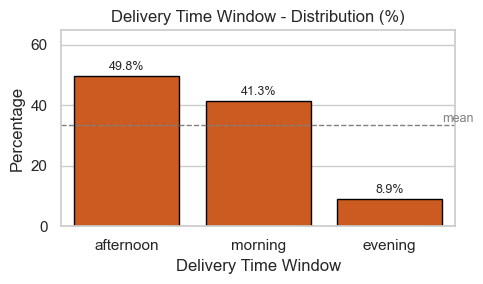

In [11]:
# Univariate Analysis | Target variable distribution
plt.figure(figsize=(5,3))

# Compute normalized frequencies (%)
freq = (df[target_variable].value_counts(normalize=True) * 100).round(2)
freq_df = freq.reset_index()
freq_df.columns = [target_variable, 'Percentage']

# Barplot
ax = sns.barplot(
    data=freq_df,
    x=target_variable,
    y='Percentage',
    color=postnl_color,
    edgecolor='black'
)

# Add percentage labels on each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + (freq_df['Percentage'].max() * 0.02),  # small offset
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='medium'
    )

# Add mean line for visual reference
mean_line = freq_df['Percentage'].mean()
plt.axhline(y=mean_line, color='gray', linestyle='--', linewidth=1)
plt.text(
    len(freq_df) - 0.6,
    mean_line + (freq_df['Percentage'].max() * 0.02),
    'mean',
    color='gray',
    fontsize=9
)

# Plot
plt.title(f"{target_variable.replace('_', ' ').title()} - Distribution (%)")
plt.ylabel("Percentage")
plt.xlabel(target_variable.replace('_', ' ').title())
plt.ylim(0, min(max(freq_df['Percentage'].max() * 1.3, 20), 100))
plt.tight_layout()
plt.show()

As anticipated by the preliminary exploration, the bar plot shows that the Delivery Time Window variable is heavily skewed, with almost half of deliveries taking place in the afternoon (49.8%), around 41% in the morning, and only 8.9% in the evening. This imbalance implies that a classification model will naturally tend to favor the most represented class (afternoon), achieving an apparently high but insignificant accuracy. It will therefore be important to evaluate performance with more balanced metrics, such as the Macro F1-score or Balanced Accuracy, and consider strategies to compensate for the scarcity of evening examples in the modeling part.  

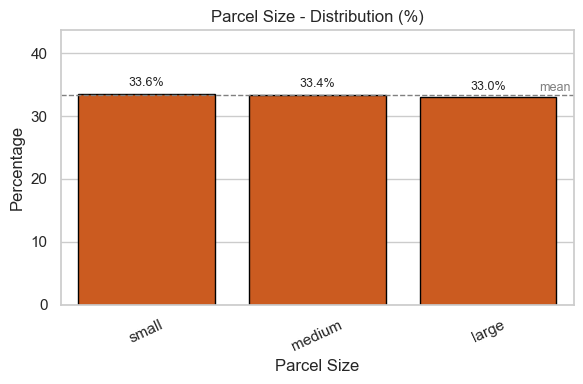

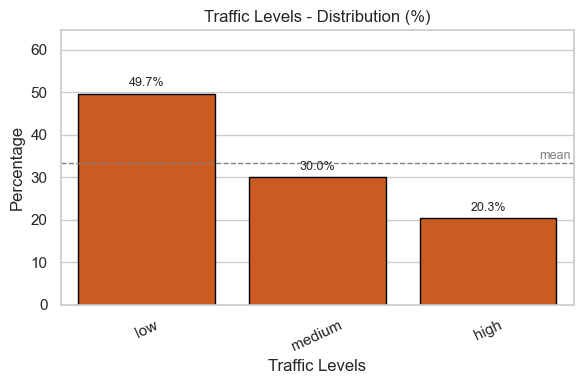

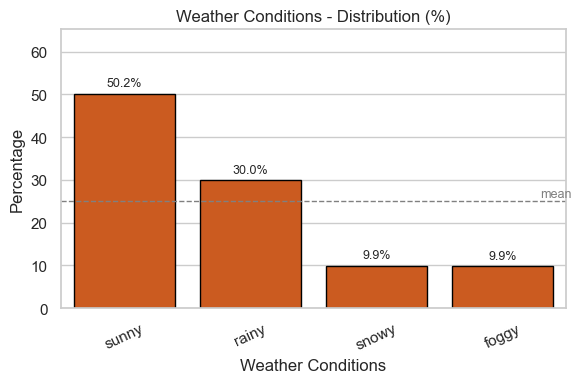

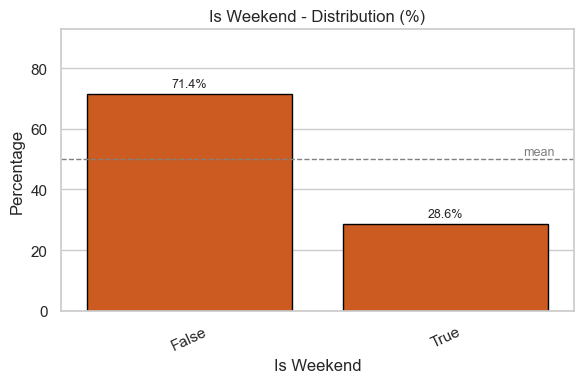

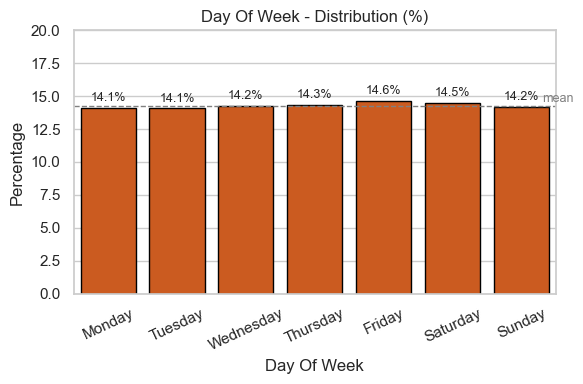

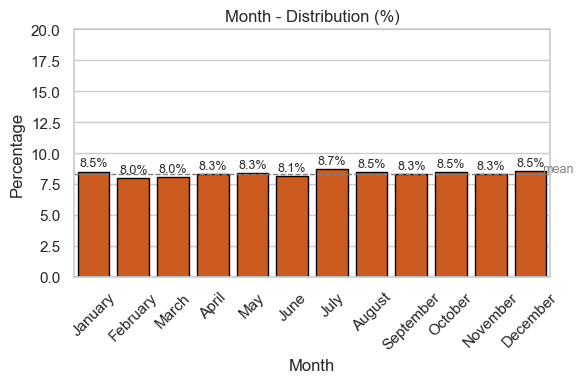

,Variable,Unique Classes,Max %,Min %,Max/Min Ratio
0,parcel_size,3,33.6,33.0,1.02
1,traffic_levels,3,49.7,20.3,2.45
2,weather_conditions,4,50.2,9.9,5.07
3,is_weekend,2,71.4,28.6,2.49
4,day_of_week,7,14.6,14.1,1.04
5,month,12,8.7,8.0,1.09


In [12]:
# Univariate Analysis | Categorical features distributions
def plot_categorical_distributions(df, cols, target_variable=None, color=postnl_color):
    """
    Plot percentage distributions for categorical features.
    Automatically adjusts proportions, skips the target variable,
    orders 'month' and 'day_of_week' logically,
    and summarizes category balance in a compact table.
    """
    summary_data = []

    # Define logical orderings
    month_order = list(calendar.month_name[1:])  # [from January to December]
    weekday_order = list(calendar.day_name)      # [from Monday to Sunday]

    for col in cols:
        if col == target_variable:
            continue  # skip target variable if included

        plt.figure(figsize=(6, 4))

        # Compute normalized frequencies
        freq = (df[col].value_counts(normalize=True) * 100).round(2)
        freq_df = freq.reset_index()
        freq_df.columns = [col, "Percentage"]

        # Handle special categorical orderings
        if col.lower() == "month":
            # Replace numeric months with names and preserve calendar order
            freq_df[col] = freq_df[col].astype(int).apply(lambda x: calendar.month_name[x])
            freq_df[col] = pd.Categorical(freq_df[col], categories=month_order, ordered=True)
            freq_df = freq_df.sort_values(by=col)

        elif col.lower() == "day_of_week":
            # Ensure days are ordered from Monday to Sunday
            freq_df[col] = pd.Categorical(freq_df[col], categories=weekday_order, ordered=True)
            freq_df = freq_df.sort_values(by=col)

        else:
            # Default: sort categories by descending frequency
            freq_df = freq_df.sort_values("Percentage", ascending=False)

        # Create the barplot
        ax = sns.barplot(
            data=freq_df,
            x=col,
            y="Percentage",
            color=color,
            edgecolor="black",
            order=freq_df[col] if col.lower() in ["month", "day_of_week"] else None
        )

        # Annotate bars
        offset = freq_df["Percentage"].max() * 0.02
        for p in ax.patches:
            height = p.get_height()
            ax.text(
                p.get_x() + p.get_width() / 2,
                height + offset,
                f"{height:.1f}%",
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="medium",
            )

        # Mean line
        mean_line = freq_df["Percentage"].mean()
        plt.axhline(y=mean_line, color="gray", linestyle="--", linewidth=1)
        plt.text(
            len(freq_df) - 0.7,
            mean_line + offset,
            "mean",
            color="gray",
            fontsize=9,
        )

        # Titles and axes
        plt.title(f"{col.replace('_', ' ').title()} - Distribution (%)")
        plt.xlabel(col.replace("_", " ").title())
        plt.ylabel("Percentage")

        rotation = 25 if len(freq_df) <= 8 else 45
        plt.xticks(rotation=rotation)

        # Dynamic y-limit for readability
        y_max = freq_df["Percentage"].max()
        plt.ylim(0, min(max(y_max * 1.3, 20), 100))

        plt.tight_layout()
        plt.show()

        # Summary stats
        max_val, min_val = freq.max(), freq.min()
        ratio = round(max_val / min_val, 2) if min_val > 0 else np.nan
        summary_data.append([col, len(freq), max_val, min_val, ratio])

    # Summary DataFrame
    summary_df = pd.DataFrame(
        summary_data,
        columns=["Variable", "Unique Classes", "Max %", "Min %", "Max/Min Ratio"],
    )

    # Display summary with conditional formatting
    display(
        summary_df.style.background_gradient(cmap="Oranges", subset=["Max/Min Ratio"]).format(
            {"Max %": "{:.1f}", "Min %": "{:.1f}", "Max/Min Ratio": "{:.2f}"}
        )
    )

    # Diagnostic summary
    uniform_vars = summary_df[summary_df["Max/Min Ratio"] < 1.5]["Variable"].tolist()
    skewed_vars = summary_df[summary_df["Max/Min Ratio"] >= 1.5]["Variable"].tolist()


# Run the function
plot_categorical_distributions(df, categorical_variables, target_variable=target_variable, color=postnl_color)

From this first graphical exploration it is possible to see that the categorical variables have two type of distributions:
- Fairly uniform distributions: parcel_size, day_of_week, month
- Noticeably skewed distributions: traffic_levels, weather_conditions, is_weekend

In particular, parcel_size are well balanced between small, medium, and large, so they do not appear to introduce bias into the model. The distribution by day of the week and month is also stable, suggesting that the data cover the entire time period evenly.

The most unbalanced variables are Weather Conditions, Is Weekend and Traffic Levels. In particular, traffic levels are more often low, and deliveries occur mainly on sunny days and during the week. This pattern is consistent with a normal operating scenario, where fewer deliveries on weekends and more frequent favorable weather or traffic conditions, but it could also simply reflect the fact that there are five weekdays and only two weekend days. I will verify whether, given the same number of days available, the average volume of deliveries really changes between weekends and weekdays or whether the difference is purely structural. In any case, these variables show that the model will have fewer examples to learn from in “extreme” conditions, such as heavy traffic or bad weather, and it will be useful to take this into account when evaluating performance as mentioned before. 

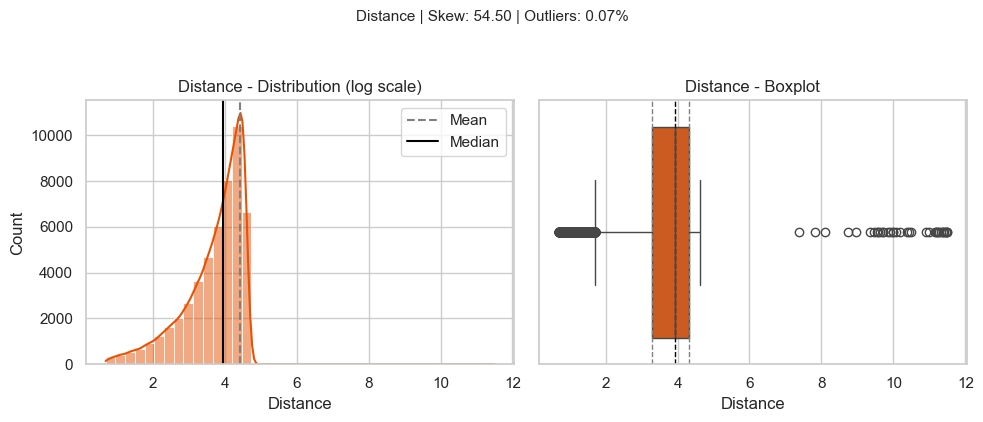

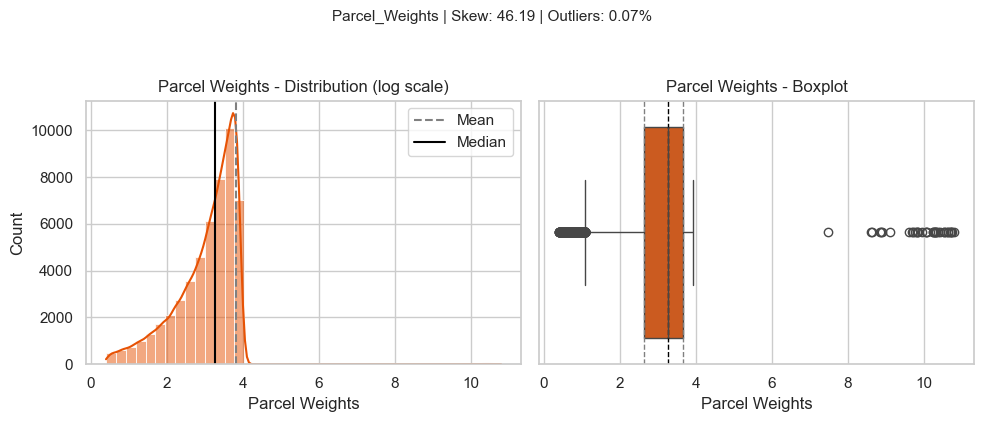

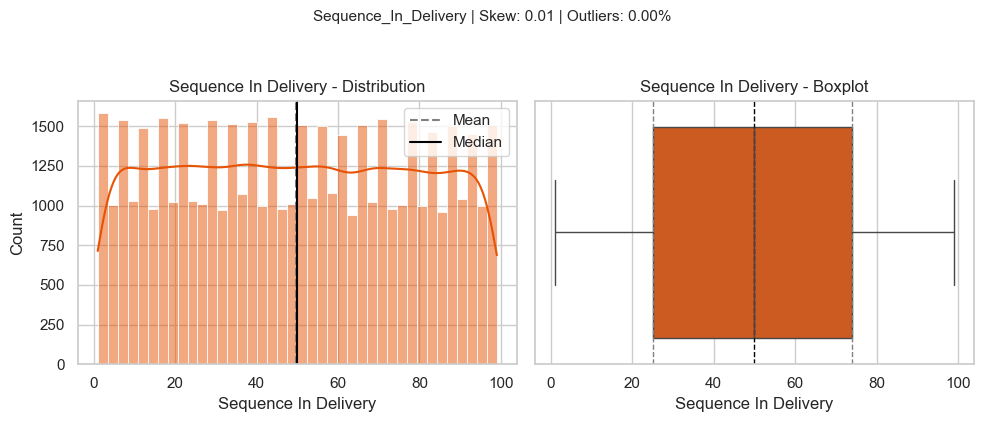

In [13]:
# Univariate Analysis | Numerical Variables 

def plot_numerical_distributions_v3(df, cols, color):
    for col in cols:
        data = df[col].dropna()

        # Basic stats
        mean_val = data.mean()
        median_val = data.median()
        q1, q3 = data.quantile([0.25, 0.75])
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr
        outliers = ((data > upper_bound) | (data < lower_bound)).sum()
        outlier_ratio = (outliers / len(data)) * 100
        skew_val = data.skew()

        # Apply log scale only if skew > 2 and all values are positive
        use_log = (skew_val > 2) and (data.min() > 0)
        scale_note = " (log scale)" if use_log else ""

        # Prepare log-transformed data only for plotting (not modifying original df)
        if use_log:
            data_plot = np.log1p(data)  # log(1 + x) safe for small values
        else:
            data_plot = data

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        #  Histogram + KDE 
        ax1 = axes[0]
        sns.histplot(data_plot, bins=40, kde=True, color=color, ax=ax1)
        ax1.axvline(mean_val if not use_log else np.log1p(mean_val),
                    color='gray', linestyle='--', label='Mean')
        ax1.axvline(median_val if not use_log else np.log1p(median_val),
                    color='black', linestyle='-', label='Median')
        ax1.legend()
        ax1.set_title(f"{col.replace('_', ' ').title()} - Distribution{scale_note}")
        ax1.set_xlabel(col.replace('_', ' ').title())
        ax1.set_ylabel("Count")

        # Boxplot
        ax2 = axes[1]
        sns.boxplot(x=data_plot, color=color, ax=ax2)
        for q, c in zip([q1, median_val, q3], ['gray', 'black', 'gray']):
            ax2.axvline(np.log1p(q) if use_log else q, color=c, linestyle='--', linewidth=1)
        ax2.set_title(f"{col.replace('_', ' ').title()} - Boxplot")
        ax2.set_xlabel(col.replace('_', ' ').title())

        plt.suptitle(f"{col.title()} | Skew: {skew_val:.2f} | Outliers: {outlier_ratio:.2f}%", fontsize=11, y=1.05)
        plt.tight_layout()
        plt.show()

# Run the function
plot_numerical_distributions_v3(df, numerical_variables, color=postnl_color)


Numerical Variables Main Insights:

`Distance:`
- the distribution is extremely skewed (54.5) with a long tail to the right. This indicates that most deliveries are over short distances; there outliers might indicate few exceptionally long ones (might worth to investigate) or some measurement errors. 
- the boxplot confirms that outliers are concentrated in the right tail, consistent with the logistic nature of the data.

`Parcel Weight:`
- the distribution is similar to distance, very skewed (46.2) with a few extremely high values.
- in the boxplot, the presence of outliers might be consistent with very heavy parcels. 
- in this case outliers may represent non-standard shipments (e.g. bulk orders or retailer) 

`Sequence in Delivery:`
- the dstribution is very uniform, with no outliers. No action needed. 

### Distance | Outliers Check

In [14]:
# Detect outliers in distance using the IQR method | NORMAL SCALE
Q1 = df['distance'].quantile(0.25)
Q3 = df['distance'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers_distance = df[df['distance'] > upper_bound].copy()

print(f"Number of distance outliers: {outliers_distance.shape[0]}")
print(f"Percentage of outliers: {round((outliers_distance.shape[0] / df.shape[0]) * 100, 3)}%")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")

outliers_distance[['distance', 'parcel_weights', 'parcel_size', 'sequence_in_delivery', 'delivery_time_window']].sample(5)

Number of distance outliers: 36
Percentage of outliers: 0.072%
Lower bound: -48.44
Upper bound: 149.27


,distance,parcel_weights,parcel_size,sequence_in_delivery,delivery_time_window
47920,18988.54,40.87,small,47.0,morning
26634,94253.14,22.07,medium,97.0,afternoon
22117,32423.13,44.39,large,52.0,afternoon
22537,70347.11,47.61,large,14.0,afternoon
13190,83918.71,44.48,large,27.0,morning


In [15]:
# Calculate number and percentage of lower and upper outliers | LOGARITHMIC TRANSFORMATION to manage skewness
num_lower_outliers = (df['distance'] < lower_bound).sum()
num_upper_outliers = (df['distance'] > upper_bound).sum()

perc_lower_outliers = (num_lower_outliers / df.shape[0]) * 100
perc_upper_outliers = (num_upper_outliers / df.shape[0]) * 100

print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")
print(f"Number of lower outliers: {num_lower_outliers} ({perc_lower_outliers:.3f}%)")
print(f"Number of upper outliers: {num_upper_outliers} ({perc_upper_outliers:.3f}%)")

Lower bound: -48.44
Upper bound: 149.27
Number of lower outliers: 0 (0.000%)
Number of upper outliers: 36 (0.072%)


In [16]:
df[df['distance'] < 4.55]['distance'].describe()

count    1762.000000
mean        2.779279
std         1.014112
min         1.000000
25%         1.910000
50%         2.795000
75%         3.630000
max         4.540000
Name: distance, dtype: float64

In [17]:
# Count how many observations are above each threshold
count_above_365 = (df['distance'] > 365.54).sum()
count_above_149 = (df['distance'] > 149.27).sum()

print(f"Number of values above 365.54: {count_above_365}")
print(f"Number of values above 149.27: {count_above_149}")

Number of values above 365.54: 36
Number of values above 149.27: 36


When analyzing the variable distance, the boxplot initially displayed apparent outliers on both the upper and lower sides.
To investigate this, two approaches were tested:

`Standard IQR method`:
The first calculation using the raw data produced a lower bound of −48.44, which is not meaningful for this variable since all recorded distances are strictly positive. This unrealistic lower limit arose because the distribution of distance is highly skewed, and a few extremely large values stretched the interquartile range.

`Log-transformed IQR method`:
To obtain more stable thresholds, the IQR was recomputed on the log-transformed distance.
With this transformation, the new bounds became 4.55 (lower) and 365.54 (upper).
This version identified 36 upper-side outliers and 1762 lower-side outliers.
After inspecting the data, the lower-side values appeared legitimate and consistent with short-distance urban deliveries, rather than anomalies.


Given these findings, only upper-bound outliers (above 365.54) were considered for further analysis, as they represent potentially abnormal long-distance deliveries. The apparent lower outliers are simply a statistical artifact of the IQR method under high skewness, not genuine anomalies.


Bounds (original scale) → Lower: 4.55, Upper: 365.54
Lower outlier ratio: 3.53%
Upper outlier ratio: 0.07%


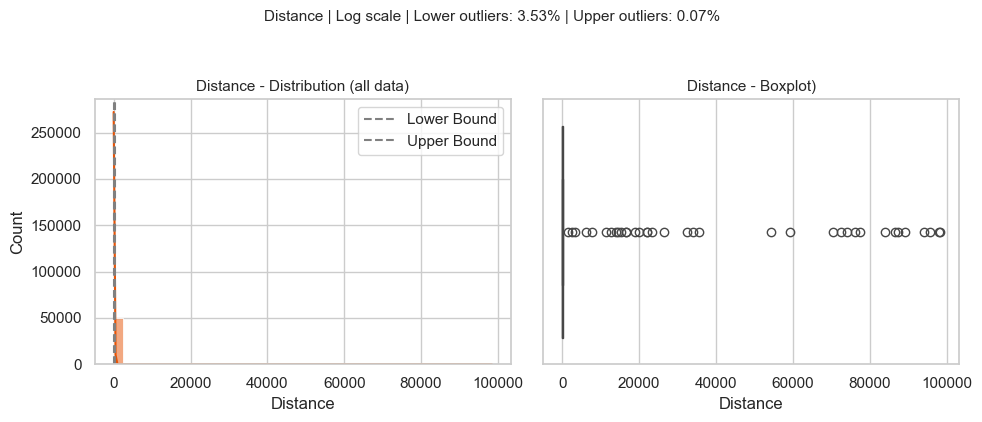

In [18]:
# Distance Boxplot and Histogram (with lower outliers)

# Calculate IQR on log scale
data_log = np.log1p(df['distance'].dropna())
Q1, Q3 = data_log.quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_bound_log = Q1 - 1.5 * IQR
upper_bound_log = Q3 + 1.5 * IQR

# Convert bounds back to original scale
lower_bound = np.expm1(lower_bound_log)
upper_bound = np.expm1(upper_bound_log)

# Keep all data 
data_full = df['distance'].dropna()

# Calculate % of upper and lower outliers
upper_outlier_ratio = (data_full > upper_bound).mean() * 100
lower_outlier_ratio = (data_full < lower_bound).mean() * 100

print(f"Bounds (original scale) → Lower: {lower_bound:.2f}, Upper: {upper_bound:.2f}")
print(f"Lower outlier ratio: {lower_outlier_ratio:.2f}%")
print(f"Upper outlier ratio: {upper_outlier_ratio:.2f}%")

# Plot setup
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram + KDE
sns.histplot(
    data=data_full,
    bins=40,
    kde=True,
    color=postnl_color,
    ax=axes[0]
)
axes[0].axvline(lower_bound, color='gray', linestyle='--', label='Lower Bound')
axes[0].axvline(upper_bound, color='gray', linestyle='--', label='Upper Bound')
axes[0].set_title('Distance - Distribution (all data)', fontsize=11)
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Count')
axes[0].legend()

# Boxplot
sns.boxplot(
    x=data_full,
    color=postnl_color,
    ax=axes[1]
)
axes[1].set_title('Distance - Boxplot)', fontsize=11)
axes[1].set_xlabel('Distance')

# Global title
plt.suptitle(
    f"Distance | Log scale | Lower outliers: {lower_outlier_ratio:.2f}% | Upper outliers: {upper_outlier_ratio:.2f}%",
    fontsize=11,
    y=1.05
)
plt.tight_layout()
plt.show()


In [19]:
# Analyze logistic profile of outlier deliveries
summary_outliers = (
    outliers_distance.groupby(['parcel_size', 'delivery_time_window'])
    .agg(
        avg_distance=('distance', 'mean'),
        avg_weight=('parcel_weights', 'mean'),
        count=('distance', 'size')
    )
    .reset_index()
    .sort_values(by='avg_distance', ascending=False)
)
summary_outliers

,parcel_size,delivery_time_window,avg_distance,avg_weight,count
1,large,evening,98400.060000,9.130000,1
0,large,afternoon,73174.295000,26.581667,6
4,medium,evening,51869.306667,26.293333,3
3,medium,afternoon,47123.144000,15.018000,5
5,medium,morning,44704.882500,13.240000,4
2,large,morning,37722.978333,27.145000,6
8,small,morning,22927.376250,28.987500,8
7,small,evening,21566.885000,42.265000,2
6,small,afternoon,15384.440000,1.610000,1


There are no strong patterns between size, time window, and distance. Extreme values are distributed across different time slots and sizes

<Axes: xlabel='delivery_time_window', ylabel='distance'>

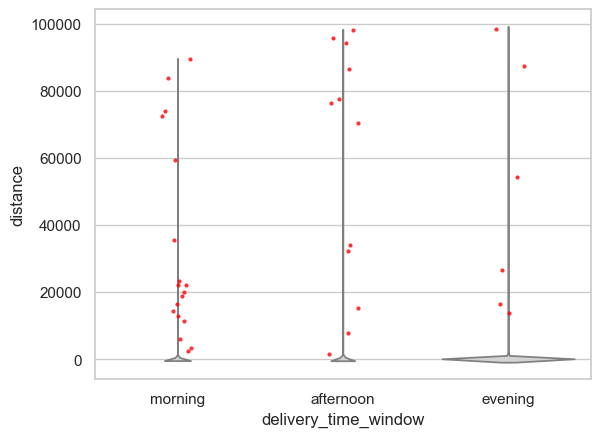

In [20]:
# Visualize outliers by delivery time window
sns.violinplot(
    data=df, x='delivery_time_window', y='distance', inner=None, color='lightgray'
)
sns.stripplot(
    data=outliers_distance, x='delivery_time_window', y='distance',
    color='red', size=3, jitter=True, alpha=0.8
)

This violin plot shows that outliers exist in all time slots but do not seem to be concentrated in any one slot.

In [21]:
outlier_corr = outliers_distance[['distance', 'parcel_weights']].corr(method='spearman')
outlier_corr

,distance,parcel_weights
distance,1.000000,-0.185586
parcel_weights,-0.185586,1.000000


In [22]:
df['distance'].describe(percentiles=[.99])

count    49906.000000
mean        81.933456
std       1480.639073
min          1.000000
50%         50.450000
99%         99.090000
max      98400.060000
Name: distance, dtype: float64

Distance Outliers Summary

Outliers in the distance variable were detected using the Interquartile Range (IQR) method.
Only 36 observations (0.073%) were identified as outliers, with some exceeding 98 000 km, which is a value that is physically impossible given that the the circumference of the Earth is approximately 40,000 km; in addiction, the operational range of delivery vehicles is typically below 100 km per day in the Netherlands.

The analysis of parcel size, weight, and delivery time window revealed no consistent patterns that could justify such extreme distances.
Correlations between distance and parcel_weights were weak (– 0.18), confirming that these anomalies are not due to heavier parcels.
Given their magnitude and implausibility, these cases are likely caused by measurement or unit errors (meters misinterpreted as kilometers or accumulated GPS readings).

For this reason, I defined a physical plausibility threshold of 5.000 km. Records beyond this limit will be removed, while the remaining ones were flagged for separate logistic analysis.

### Parcel Weights | Outliers Check

Since parcel weight has a high skewness like the distance variable, I will directly test the interquartile range with logarithmic transformation.

In [23]:
# Detect outliers in parcel_weights using the IQR method

Q1 = df['parcel_weights'].quantile(0.25)
Q3 = df['parcel_weights'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers_weight = df[(df['parcel_weights'] < lower_bound) | (df['parcel_weights'] > upper_bound)].copy()

print(f"Number of parcel weight outliers: {outliers_weight.shape[0]}")
print(f"Percentage of outliers: {round((outliers_weight.shape[0] / df.shape[0]) * 100, 3)}%")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")

outliers_weight[['parcel_weights', 'parcel_size', 'distance', 'sequence_in_delivery', 'delivery_time_window']].sample(5)


Number of parcel weight outliers: 37
Percentage of outliers: 0.074%
Lower bound: -24.18
Upper bound: 74.46


,parcel_weights,parcel_size,distance,sequence_in_delivery,delivery_time_window
29728,44124.73,small,5.72,81.0,afternoon
14471,32283.53,small,99.34,99.0,evening
39809,27812.29,large,48.79,29.0,morning
33110,39704.32,large,54.33,10.0,morning
26022,16731.61,small,3.67,81.0,afternoon


In [24]:
# Compare indexes of both outlier sets
common_outliers = set(outliers_distance.index).intersection(set(outliers_weight.index))

print(f"Number of overlapping outliers: {len(common_outliers)}")

if len(common_outliers) > 0:
    display(df.loc[list(common_outliers), ['distance', 'parcel_weights', 'parcel_size', 'delivery_time_window']].head())


Number of overlapping outliers: 0


In [25]:
# Merge to compare rows with same extreme values of distance and parcel_weights
merged_outliers = pd.merge(
    outliers_distance[['distance', 'parcel_weights']],
    outliers_weight[['distance', 'parcel_weights']],
    on=['distance', 'parcel_weights'],
    how='inner'
)

print(f"Number of overlapping outliers (based on values): {merged_outliers.shape[0]}")

if not merged_outliers.empty:
    display(merged_outliers.head())


Number of overlapping outliers (based on values): 0


In [26]:
# Count above the 30 kg threshold (internet research for PostNL heavy parcel limit)
threshold_30 = 30
num_above_30 = (df['parcel_weights'] > threshold_30).sum()
perc_above_30 = num_above_30 / df.shape[0] * 100

print(f"Observations with parcel_weights > {threshold_30} kg: {num_above_30} ({perc_above_30:.3f}%)")

# Count above the 74.46 kg upper bound
threshold_ub = 74.46
num_above_ub = (df['parcel_weights'] > threshold_ub).sum()
perc_above_ub = num_above_ub / df.shape[0] * 100

print(f"Observations with parcel_weights > {threshold_ub} kg: {num_above_ub} ({perc_above_ub:.3f}%)")


Observations with parcel_weights > 30 kg: 20147 (40.294%)
Observations with parcel_weights > 74.46 kg: 37 (0.074%)


Text(0, 0.5, 'log(parcel_weights)')

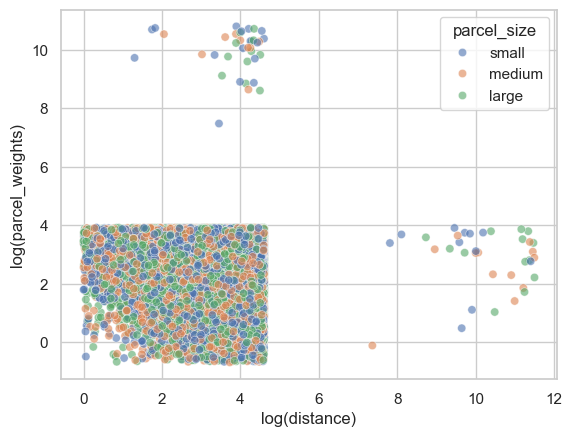

In [27]:
# Scatterplot distance vs parcel_weights with log transformation 
# Initially I tried log1p and not log to handle zero values but decided to use log since there are no zero values in these columns
sns.scatterplot(
    data=df, 
    x=np.log(df['distance']), 
    y=np.log(df['parcel_weights']),
    hue='parcel_size', alpha=0.6
)
plt.xlabel("log(distance)")
plt.ylabel("log(parcel_weights)")

After applying the logarithmic scale, we can see that most deliveries are grouped in the lower left corner, where both distance and parcel weight have normal and realistic values.
There are a few separate points with very high distances or very heavy parcels, which likely come from data entry or unit errors rather than real deliveries.
There’s no visible pattern between the two variables and therefore distance and parcel weight do not seem to be related.

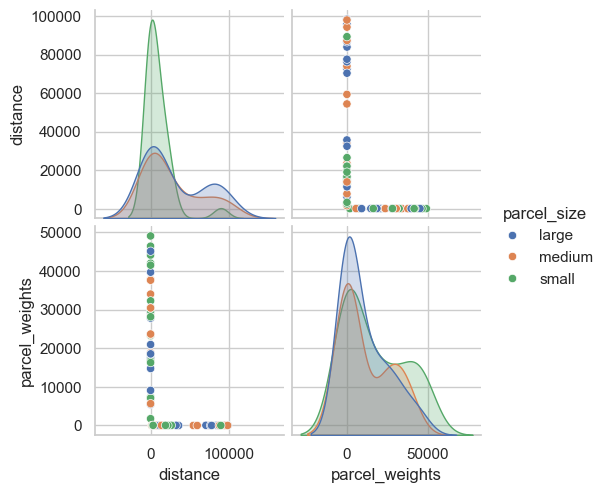

In [28]:
# Visualize outliers in distance and parcel_weights
outliers_df = df[(df['distance'] > 365.54) | (df['parcel_weights'] > 74.46)]
sns.pairplot(outliers_df[['distance', 'parcel_weights', 'parcel_size', 'delivery_time_window']], hue='parcel_size')

The hexbin plot shows that almost all deliveries are concentrated in one dense area, while the extreme values are rare and far apart.
This confirms that distance and parcel weight are independent, and that the majority of the data is consistent and behaves as expected.

In [29]:
df[['distance', 'parcel_weights']].corr(method='spearman')

,distance,parcel_weights
distance,1.000000,-0.004219
parcel_weights,-0.004219,1.000000


Spearman's correlation confirms the absence of any monotonic relationship between distance and package weight. I think it made sense to test it in addition to Pearson's, given that the data show strong skewness.

count       37.000000
mean     25840.541081
std      13455.453867
min       1767.900000
25%      16731.610000
50%      27812.290000
75%      37628.610000
90%      44500.786000
95%      45397.980000
99%      48135.810400
max      49087.600000
Name: parcel_weights, dtype: float64


avg_weight  max_weight  count
parcel_size delivery_time_window                                 
small       evening               42145.333333    49087.60      3
large       evening               33054.950000    45136.54      2
medium      afternoon             31436.950000    37834.54      3
small       afternoon             24847.231538    46443.74     13
medium      morning               24589.152000    34034.58      5
            evening               23556.830000    23556.83      1
large       afternoon             20036.006000    30493.14      5
            morning               19909.328000    39704.32      5

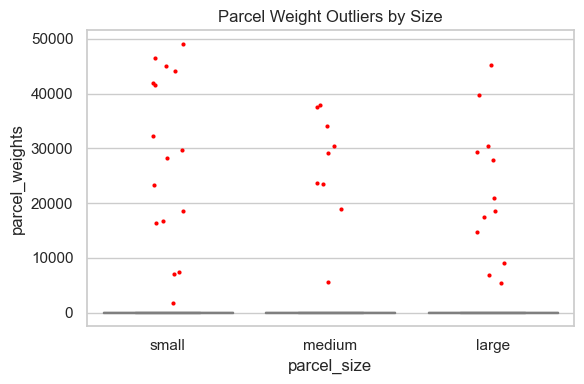

                      parcel_weights  distance  sequence_in_delivery
parcel_weights              1.000000 -0.004219              0.001233
distance                   -0.004219  1.000000              0.014426
sequence_in_delivery        0.001233  0.014426              1.000000


,dates,distance,parcel_size,parcel_weights,traffic_levels,weather_conditions,sequence_in_delivery,delivery_time_window,day_of_week,month,is_weekend
7134,2024-08-29,49.16,small,49087.60,medium,foggy,87.0,evening,Thursday,8.0,False
32026,2024-01-23,6.20,small,46443.74,low,rainy,89.0,afternoon,Tuesday,1.0,False
35131,2024-01-11,77.22,large,45136.54,medium,sunny,88.0,evening,Thursday,1.0,False
6584,2024-03-25,67.25,small,45064.87,medium,foggy,96.0,evening,Monday,3.0,False
29728,2024-09-14,5.72,small,44124.73,low,foggy,81.0,afternoon,Saturday,9.0,True
46031,2023-11-27,94.05,small,42023.32,low,rainy,88.0,afternoon,Monday,11.0,False
48813,2024-04-27,55.94,small,41523.29,medium,foggy,98.0,afternoon,Saturday,4.0,True
33110,2024-08-25,54.33,large,39704.32,low,rainy,10.0,morning,Sunday,8.0,True
16377,2024-02-10,48.69,medium,37834.54,medium,rainy,88.0,afternoon,Saturday,2.0,True
27725,2023-10-19,7.76,medium,37628.61,low,rainy,65.0,afternoon,Thursday,10.0,False


In [30]:
# Examine extreme parcel weight values in detail

# Sort and inspect the heaviest parcels
outliers_weight = df[df['parcel_weights'] > upper_bound].copy()
outliers_weight_sorted = outliers_weight.sort_values(by='parcel_weights', ascending=False)

# Basic summary of the outliers
summary_stats = outliers_weight['parcel_weights'].describe(percentiles=[.25, .5, .75, .9, .95, .99])
print(summary_stats)

# Check how parcel size and delivery window are distributed among the outliers
weight_profile = (
    outliers_weight
    .groupby(['parcel_size', 'delivery_time_window'])
    .agg(
        avg_weight=('parcel_weights', 'mean'),
        max_weight=('parcel_weights', 'max'),
        count=('parcel_weights', 'size')
    )
    .sort_values(by='avg_weight', ascending=False)
)
display(weight_profile)

# Boxplot
plt.figure(figsize=(6, 4))

sns.boxplot(
    data=df,
    x='parcel_size',
    y='parcel_weights',
    showfliers=False,
    color='lightgray'
)
sns.stripplot(
    data=outliers_weight,
    x='parcel_size',
    y='parcel_weights',
    color='red',
    size=3
)

plt.title('Parcel Weight Outliers by Size', fontsize=12)
plt.xlabel('parcel_size')
plt.ylabel('parcel_weights')
plt.tight_layout()
plt.show()

# Correlation check
corr_features = ['parcel_weights', 'distance', 'sequence_in_delivery']
corr_matrix = df[corr_features].corr(method='spearman')
print(corr_matrix)

# Inspect the top 10 heaviest parcels
display(outliers_weight_sorted.head(10))


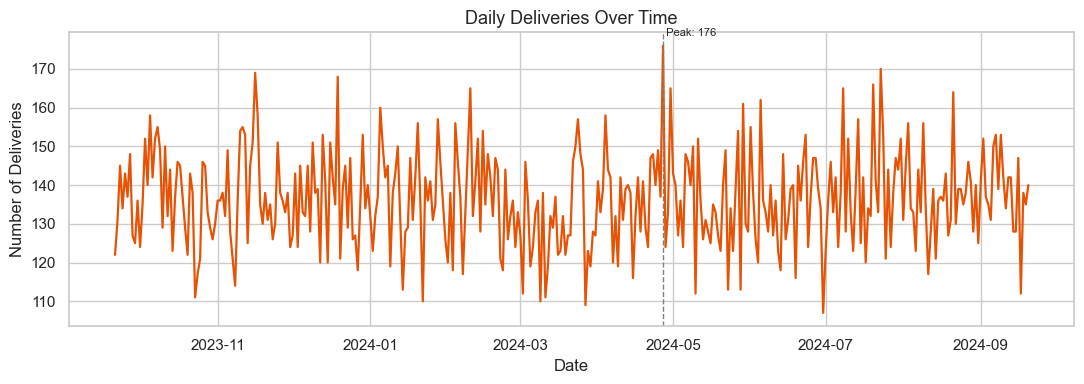

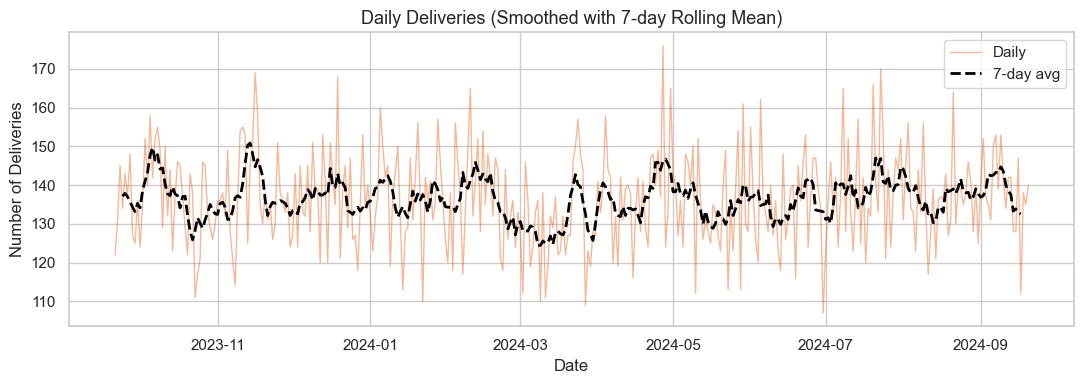

In [31]:
# Univariate Analysis | Temporal Variables 

# Daily deliveries (raw counts)
daily_trend = df.groupby('dates').size().reset_index(name='deliveries')

plt.figure(figsize=(11, 4))
sns.lineplot(data=daily_trend, x='dates', y='deliveries', color=postnl_color, linewidth=1.6)
plt.title("Daily Deliveries Over Time", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Number of Deliveries")

# Highlight the peak
max_date = daily_trend.loc[daily_trend['deliveries'].idxmax(), 'dates']
max_val = daily_trend['deliveries'].max()
plt.axvline(max_date, color='gray', linestyle='--', linewidth=1)
plt.text(max_date, max_val + 2, f" Peak: {max_val}", fontsize=8, va='bottom', ha='left')

plt.tight_layout()
plt.show()

# Smoothed daily trend (7-day rolling mean)
daily_trend['rolling_mean'] = daily_trend['deliveries'].rolling(window=7, center=True).mean()

plt.figure(figsize=(11, 4))
sns.lineplot(
    data=daily_trend, x='dates', y='deliveries',
    color=postnl_color, alpha=0.4, linewidth=1, label='Daily'
)
sns.lineplot(
    data=daily_trend, x='dates', y='rolling_mean',
    color='black', linestyle='--', linewidth=2, label='7-day avg'
)
plt.title("Daily Deliveries (Smoothed with 7-day Rolling Mean)", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Number of Deliveries")
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
# Create a temporary datetime version of the date column
df_temp = df.copy()
df_temp['dates_dt'] = pd.to_datetime(df_temp['dates'])

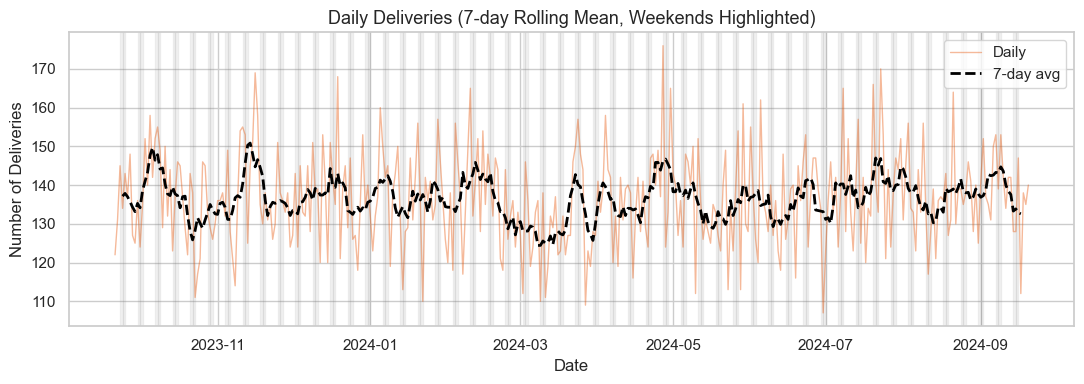

In [33]:
# Smoothed daily trend (7-day rolling mean) with weekend shading

# Use df_temp to avoid conflicts with date type
daily_trend = df_temp.groupby('dates_dt').size().reset_index(name='deliveries').copy()

# Calculate 7-day rolling mean
daily_trend['rolling_mean'] = (
    daily_trend['deliveries'].rolling(window=7, center=True).mean()
)

# Create weekend indicator (Saturday=5, Sunday=6)
daily_trend['is_weekend'] = daily_trend['dates_dt'].dt.dayofweek >= 5 
plt.figure(figsize=(11, 4))

# Daily line
sns.lineplot(
    data=daily_trend, x='dates_dt', y='deliveries',
    color=postnl_color, alpha=0.4, linewidth=1, label='Daily'
)

# Moving average line
sns.lineplot(
    data=daily_trend, x='dates_dt', y='rolling_mean',
    color='black', linestyle='--', linewidth=2, label='7-day avg'
)

# Highlight weekends
for i in range(len(daily_trend) - 1):
    if daily_trend['is_weekend'].iloc[i]:
        plt.axvspan(
            daily_trend['dates_dt'].iloc[i],
            daily_trend['dates_dt'].iloc[i + 1],
            color='gray', alpha=0.1
        )

plt.title("Daily Deliveries (7-day Rolling Mean, Weekends Highlighted)", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Number of Deliveries")
plt.legend()
plt.tight_layout()
plt.show()


Key observations:

- Clear weekly seasonality: delivery frequency tends to decrease during weekends (grey areas) and then rise again at the beginning of the week. This could be due to reduced logistics activity or lower demand on weekends.
- Medium-term stability: the moving average (dashed line) remains stable over time, fluctuating around a constant average number of daily deliveries (approximately 130–140). The volume of deliveries appears to be constant throughout the year analyzed.
- There are some peaks (above 160 daily deliveries) that could be linked to periods of high demand (e.g. promotions, holidays, or seasonal peaks).
- In general, there are no systematic increases or decreases on a monthly or seasonal basis, such as seasonal trends. 

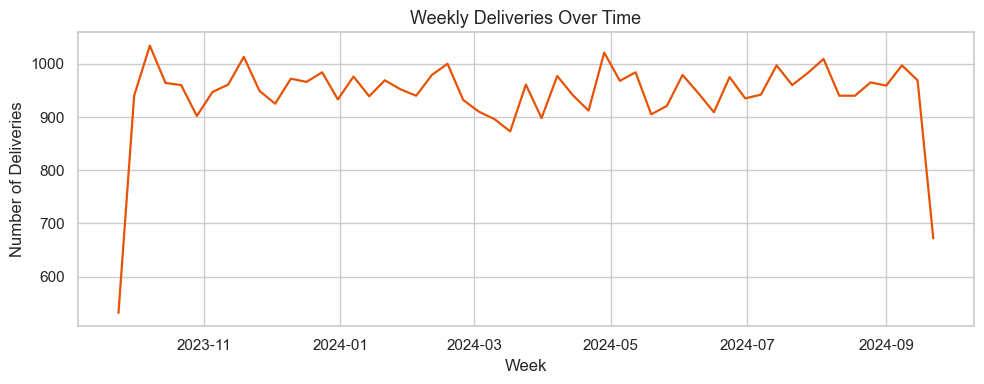

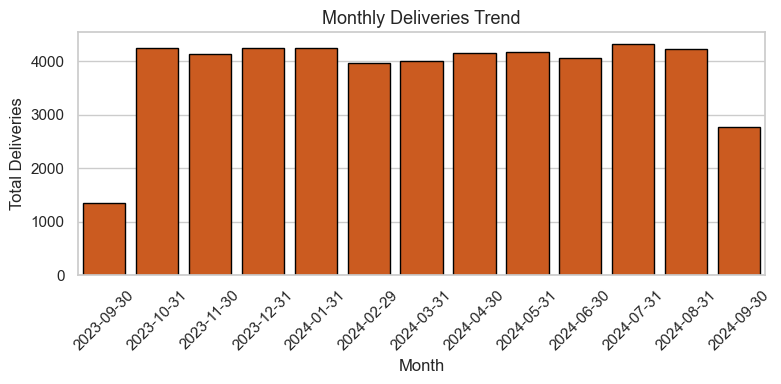

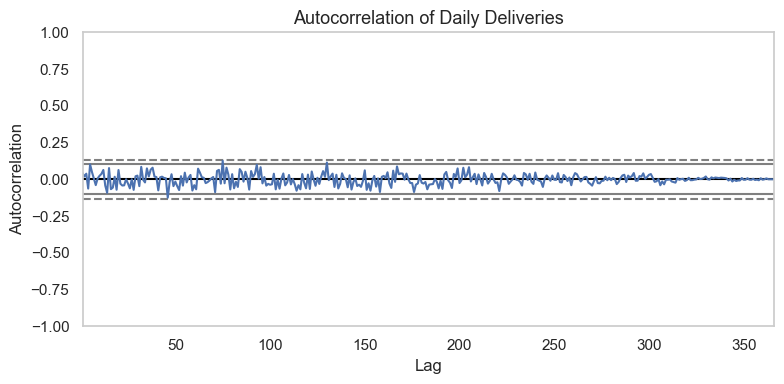

In [34]:
# Check Seasonality and Autocorrelation 

# Weekly seasonality
weekly_trend = (
    df_temp.groupby(pd.Grouper(key='dates_dt', freq='W'))
    .size()
    .reset_index(name='deliveries')
)

plt.figure(figsize=(10, 4))
sns.lineplot(data=weekly_trend, x='dates_dt', y='deliveries', color=postnl_color, linewidth=1.6)
plt.title("Weekly Deliveries Over Time", fontsize=13)
plt.xlabel("Week")
plt.ylabel("Number of Deliveries")
plt.tight_layout()
plt.show()

# Monthly seasonality
monthly_trend = (
    df_temp.groupby(pd.Grouper(key='dates_dt', freq='M'))
    .size()
    .reset_index(name='deliveries')
)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=monthly_trend,
    x='dates_dt',
    y='deliveries',
    color=postnl_color,
    edgecolor='black'
)
plt.title("Monthly Deliveries Trend", fontsize=13)
plt.xlabel("Month")
plt.ylabel("Total Deliveries")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Autocorrelation analysis
daily_counts = df_temp.groupby('dates_dt').size()

plt.figure(figsize=(8, 4))
autocorrelation_plot(daily_counts)
plt.title("Autocorrelation of Daily Deliveries", fontsize=13)
plt.tight_layout()
plt.show()

The analysis of seasonality and autocorrelation shows that the delivery system is stable over time:
- Weekly trend: weekly deliveries fluctuate slightly but without obvious seasonal patterns.
- Monthly trend: monthly volumes remain virtually constant with no upward or downward trend.
- Autocorrelation: no significant correlation between days, which means that observations can be considered independent.

In general, there is no significant seasonal or temporal dynamics emerging from the data. The data can therefore be treated as independent over time, allowing to proceed with multivariate analysis focusing on operational and spatial factors (distance, weight, weather) as the main drivers of delivery performance.

<a id="4-2"></a>

## [4.2 Correlation Analysis](#4-2)

<a id="4-2-1"></a>

### [4.2.1 Correlation | Numerical Variables ](#4-2-1)

In [35]:
# Encode target variable
target_map = {'morning': 0, 'afternoon': 1, 'evening': 2}
df['target_encoded'] = df['delivery_time_window'].map(target_map)

# Add the target variable to the numeric list
corr_features = numerical_variables + ['target_encoded']

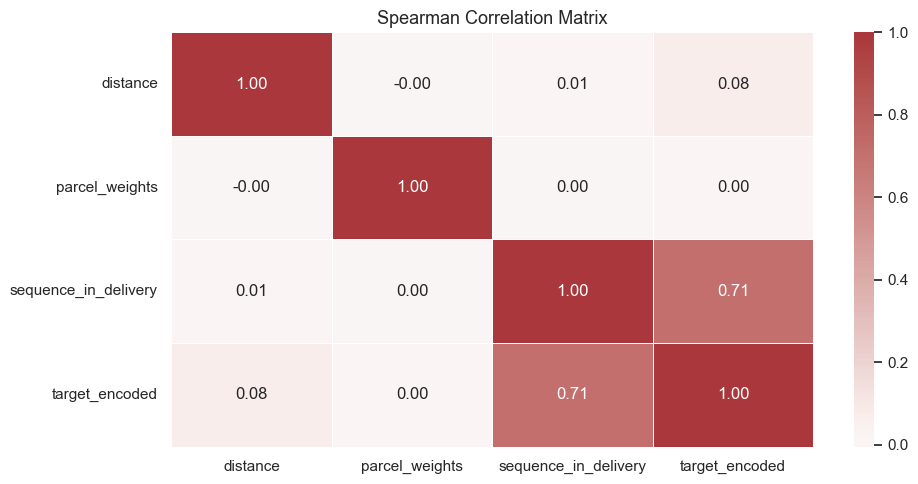

In [36]:
# SPEARMAN CORRELATION MATRIX
corr_spearman = df[corr_features].corr(method='spearman')

plt.figure(figsize=(10, 5))
sns.heatmap(
    corr_spearman,
    annot=True,
    cmap=sns.color_palette("vlag", as_cmap=True),
    center=0,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Spearman Correlation Matrix", fontsize=13)
plt.tight_layout()
plt.show()

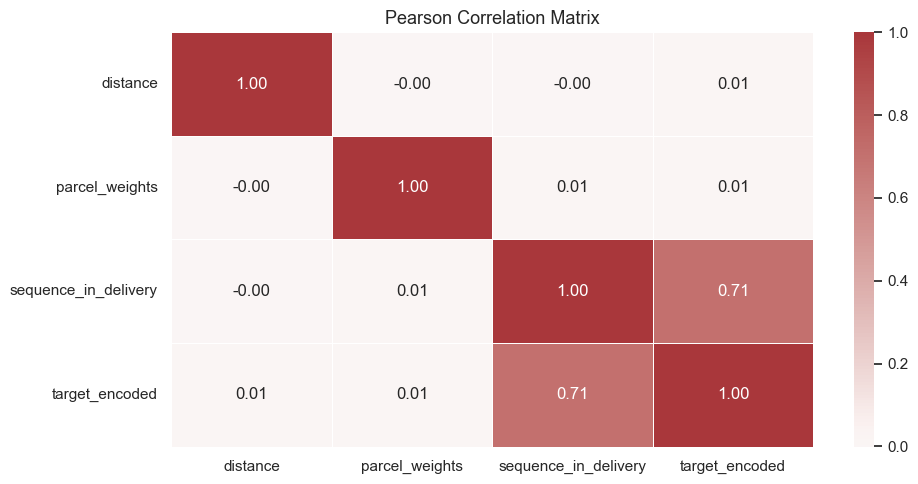

In [37]:
# SPEARMAN CORRELATION MATRIX
corr_pearson = df[corr_features].corr(method='pearson')

plt.figure(figsize=(10, 5))
sns.heatmap(
    corr_pearson,
    annot=True,
    cmap=sns.color_palette("vlag", as_cmap=True),
    center=0,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Pearson Correlation Matrix", fontsize=13)
plt.tight_layout()
plt.show()

In [38]:
# MULTICOLLINEARITY CHECK USING VIF

# Select numerical variables (create a temporary copy because I haven't fix the nan values yet)
X = df[numerical_variables].copy()

# Add constant term for intercept
X = sm.add_constant(X)

# Remove rows with missing values to avoid errors in VIF calculation (just for this calculation)
X_clean = X.dropna()

# Compute VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_clean.columns
vif_data["VIF"] = [variance_inflation_factor(X_clean.values, i) for i in range(X_clean.shape[1])]

# Remove the constant term from the results
vif_data = vif_data[vif_data["Variable"] != "const"].reset_index(drop=True)

display(vif_data)

,Variable,VIF
0,distance,1.000000
1,parcel_weights,1.000182
2,sequence_in_delivery,1.000182


I performed two different correlation analysis as:
- **Pearson correlation**: measures linear relationships between variables (but more sensitive to outliers and scale).
- **Spearman correlation**: measures monotonic relationships (ordered relationship, not necessarily linear). 
  
Main findings:
- Since both matrices look similar, the relationships seem predominantly monotonic and compatible with an approximately linear trend, although this alone does not establish linearity.
- Strong correlation between sequence_in_delivery and the target delivery_time_window. It seems logical as deliveries made earlier in the route tend to be in the morning, while later ones are in the afternoon or evening. It will be important to verify whether the delivery sequence is known before or after route scheduling.
- Very weak correlation for distance and parcel_weights but they might still matter in combination with other factors such as the traffic and the weather.

After that, I used the VIF (variance inflation factor) test to assess potential multicollinearity among numerical variables, which is how much the variance of a regression coefficient is inflated by linear relationships with other predictors.:
- VIF = 1 no linear correlation with other variables
- VIF > 5 moderate multicollinearity (some redundancy)
- VIF > 10 strong multicollinearity, which can cause instability in linear models (e.g. linear or logistic regression)

As all features have VIF values close to 1, there is little evidence of linear multicollinearity. This means that each variables could be linearly independent and contribute unique information to the model.
Therefore, at this stage it seems that no variable needs to be removed or transformed. 

<a id="4-2-2"></a>

### [4.2.2 Correlation | Categorical Variables ](#4-2-2)

In [39]:
# CHI-SQUARED TEST FOR CATEGORICAL VARIABLES
results = []

# Loop through all categorical variables
for col in categorical_variables:
    contingency_table = pd.crosstab(df[col], df[target_variable])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    results.append({
        'Variable': col,
        'Chi2': round(chi2, 2),
        'p-value': round(p_value, 4),
        'Degrees of freedom': dof
    })

results_chi2 = pd.DataFrame(results).sort_values(by='p-value')

display(results_chi2)

,Variable,Chi2,p-value,Degrees of freedom
1,traffic_levels,8214.80,0.0000,4
2,weather_conditions,2462.60,0.0000,6
3,is_weekend,2062.97,0.0000,2
4,day_of_week,2070.58,0.0000,12
5,month,30.94,0.0973,22
0,parcel_size,2.41,0.6610,4


In [40]:
# CRAMÉR’S V FOR CATEGORICAL VARIABLES

def cramers_v(x, y):
    """
    Compute Cramér’s V for two categorical variables.
    """
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    k = min(contingency_table.shape) - 1
    return np.sqrt((chi2 / n) / k)

# Compute Cramér’s V for all categorical variables vs target
results_c = []
for col in categorical_variables:
    v = cramers_v(df[col], df[target_variable])
    results_c.append((col, round(v, 3)))

cramers_df = pd.DataFrame(results_c, columns=['Variable', "Cramér’s V"])
display(cramers_df.sort_values(by="Cramér’s V", ascending=False))


,Variable,Cramér’s V
1,traffic_levels,0.287
3,is_weekend,0.203
2,weather_conditions,0.157
4,day_of_week,0.144
5,month,0.018
0,parcel_size,0.005


Since categorical variables cannot be included in Pearson or Spearman correlation matrices, two specific statistical tests were applied:

- **Chi-square test**: checks whether a variable is independent from or associated with the target.
A p-value < 0.05 indicates a statistically significant association, while higher values suggest the variable alone may have limited explanatory power.

- **Cramér’s V**: measures the strength of association between two categorical variables (0 = none, 1 = perfect).
The strength can be classified as weak (0.00–0.10), moderate (0.10–0.25), relatively strong (0.25–0.40), or very strong (> 0.40).

Results show that the delivery time window is strongly influenced by traffic levels and whether the delivery occurs on a weekend or weekday.
Weather conditions and day of week have a smaller impact, while month and parcel size appear to add little predictive value.

In the multivariate analysis, I will verify whether these relationships remain significant when controlling for multiple features simultaneously, or if their combined effects reveal different patterns.

<a id="4-3"></a>

## [4.3 Multivariate Analysis](#4-3)

<a id="4-3-1"></a>

### [4.3.1 Temporal Variables vs Target ](#4-3-1)

This section explores how temporal variables (day of week, month, weekend indicator, and dates) relate to the delivery time window (morning, afternoon, evening).

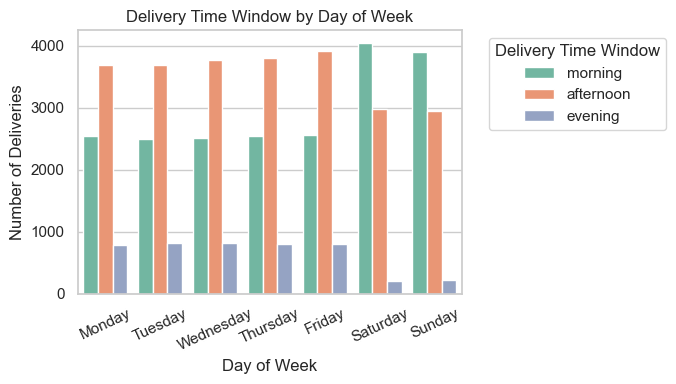

In [41]:
# Delivery Time Window by Day of Week
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(7,4))
sns.countplot(data=df, x='day_of_week', hue=target_variable, order=order_days, palette='Set2')
plt.title("Delivery Time Window by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Deliveries")
plt.xticks(rotation=25)
plt.legend(title=target_variable.replace('_', ' ').title(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


- Morning and afternoon deliveries dominate weekly activity.
- Saturdays show a sharp increase in morning deliveries and a reduction in afternoon deliveries; this is likely because of logistical reorganization or a reduction in afternoon shifts.
- Sundays have a lower total volume but proportionally more morning deliveries than other days.

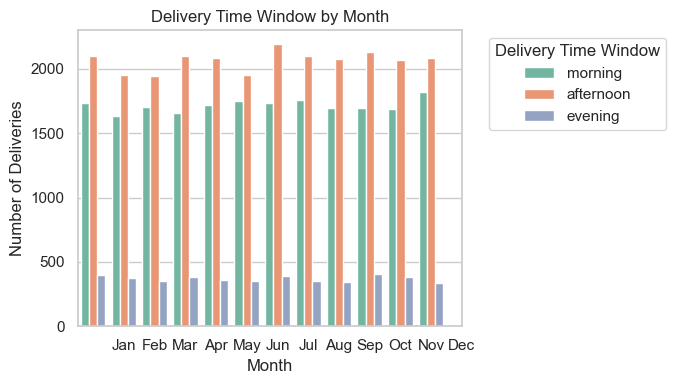

In [42]:
# Delivery Time Window by Month

# Ensure month column is integer and drop NaN rows only for plotting
df_temp = df_temp.dropna(subset=['month']).copy()
df_temp['month'] = df_temp['month'].astype(int)

# 2. Delivery Time Window by Month
month_order = list(range(1, 13))
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(7, 4))
sns.countplot(data=df_temp, x='month', hue=target_variable,
              order=month_order, palette='Set2')
plt.title("Delivery Time Window by Month")
plt.xlabel("Month")
plt.ylabel("Number of Deliveries")
plt.xticks(ticks=month_order, labels=month_labels)
plt.legend(title=target_variable.replace('_', ' ').title(),
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

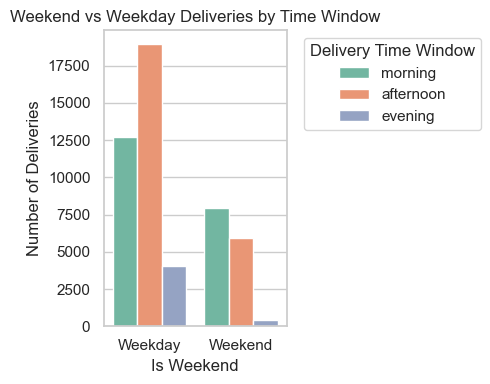

In [43]:
# Weekend vs Weekday Deliveries
plt.figure(figsize=(5,4))
sns.countplot(data=df, x='is_weekend', hue=target_variable, palette='Set2')
plt.title("Weekend vs Weekday Deliveries by Time Window")
plt.xlabel("Is Weekend")
plt.ylabel("Number of Deliveries")
plt.xticks([0,1], ['Weekday', 'Weekend'])
plt.legend(title=target_variable.replace('_', ' ').title(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

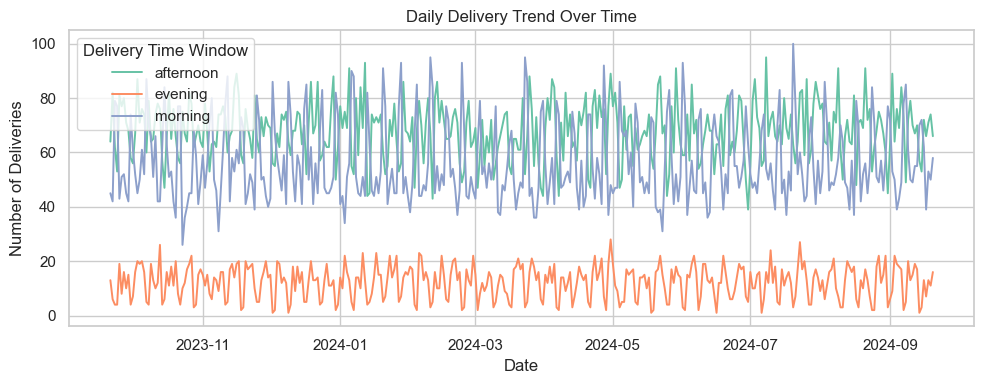

In [44]:
# Daily Delivery Trend Over Time
daily_trend = df.groupby(['dates', target_variable]).size().reset_index(name='count')

plt.figure(figsize=(10,4))
sns.lineplot(data=daily_trend, x='dates', y='count', hue=target_variable, palette='Set2', linewidth=1.4)
plt.title("Daily Delivery Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Deliveries")
plt.legend(title=target_variable.replace('_', ' ').title())
plt.tight_layout()
plt.show()

Key findings:

- **Day of Week**: deliveries show a clear weekly pattern. Most weekday deliveries occur in the afternoon, while morning deliveries are more frequent during weekends. Evening deliveries remain consistently low across all days.
- **Month**: the distribution of deliveries by month remains remarkably stable. There are no significant seasonal fluctuations in delivery time windows, suggesting that monthly seasonality does not influence delivery timing.
- **Weekend vs Weekday**: weekends show a higher proportion of morning deliveries, while weekdays are dominated by afternoon deliveries; this pattern aligns with operational constraints such as shorter working hours or reduced delivery shifts during weekends.
- **Overall Temporal Trend**: the daily time-series plot shows steady delivery volumes across the year with no strong upward or downward trends, indicating that delivery scheduling is consistent over time.

Temporal features such as day_of_week and is_weekend may contribute useful signals to the model, capturing weekly operational cycles.  
However, month appears to have limited predictive power for delivery time window classification and can likely be deprioritized in the modeling phase.


<a id="4-3-2"></a>

### [4.3.2 Logistics Features vs Target ](#4-3-2)

/var/folders/jb/nvy3v4hn4mv7g_jtj04zp7pc0000gn/T/ipykernel_50835/1033510450.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_variable, y=col, ax=axes[i], palette='Set2')
/var/folders/jb/nvy3v4hn4mv7g_jtj04zp7pc0000gn/T/ipykernel_50835/1033510450.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_variable, y=col, ax=axes[i], palette='Set2')
/var/folders/jb/nvy3v4hn4mv7g_jtj04zp7pc0000gn/T/ipykernel_50835/1033510450.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_variable, y=col, ax

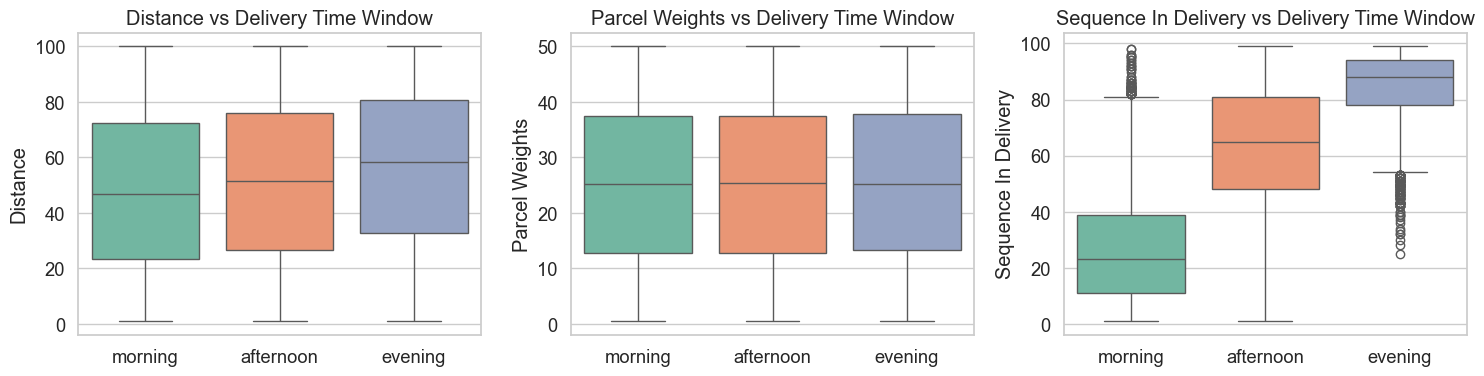

In [95]:
# Distribution of logistic variables by delivery window

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(numerical_variables):
    sns.boxplot(data=df, x=target_variable, y=col, ax=axes[i], palette='Set2')
    axes[i].set_title(f"{col.replace('_',' ').title()} vs {target_variable.replace('_',' ').title()}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel(col.replace('_',' ').title())
plt.tight_layout()
plt.show()

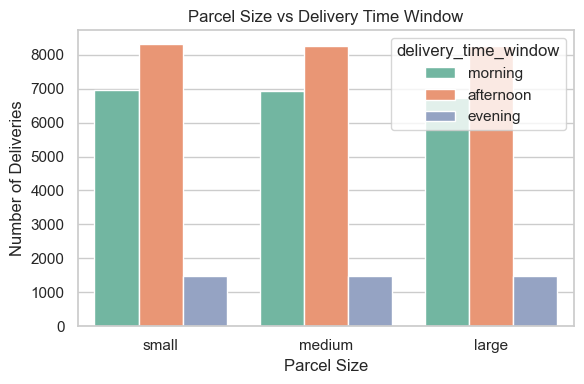

In [46]:
# Parcel size distribution by delivery window

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='parcel_size', hue=target_variable, palette='Set2')
plt.title("Parcel Size vs Delivery Time Window")
plt.xlabel("Parcel Size")
plt.ylabel("Number of Deliveries")
plt.tight_layout()
plt.show()

<a class="anchor" id="5">

# 5. Data Preparation & Feature Engineering
    
</a>

This section covers the main preprocessing steps applied to ensure data quality and consistency before analysis and modeling:
1. Missing Values: detection and handling of missing data.
2. Outliers: identification and treatment of anomalous values.
3. Feature Engineering:creation of new informative variables.
4. Drop Features: removal of redundant or irrelevant features.

<a id="5-1"></a>

## [5.1 Data Cleaning](#5-1)


### Missing Values

As shown during the preliminary exploration (Section 3), the missing values are only 0.12% of the dataset (482 out of 50.000 rows), with each variable affected by less than 0.2%. As these percentages are really low, the best solution seems to drop them directly rather than imputed.

Imputation methods (e.g. mean, mode, KNN, or regression-based) are typically justified when the percentage of missing data is higher or when missingness is non-random. In this case, removal avoids introducing artificial noise and preserves the natural relationships among variables.

In [48]:
# Drop rows with missing values (since % is very low)
df = df.dropna().reset_index(drop=True)
print(f"{df.shape[0]} rows remaining")

49519 rows remaining


### Outliers 

`Distance Outliers Summary`

The outliers in the distance variable were examinated in the Section 4.1.1 of this notebook (Distance | Outliers Check). 
They were detected using both the standard Interquartile Range (IQR) and the log-transformed IQR methods to account for the strong right-skewed distribution of the data. 
- The standard IQR produced unrealistic results, with a negative lower bound (−48.44) due to the long right tail of the distribution. 
- After applying a logarithmic transformation, the bounds became 4.55 (lower) and 365.54 (upper). 
- Both approaches identified 36 upper-side outliers (0.073%), confirming their robustness.

The additional 1762 lower-side outliers found in the log-transformed version were inspected and confirmed to represent legitimate short-distance deliveries, not anomalies.
Some outlier distances exceeded 98,000 km, which is physically impossible given that:
- The Earth’s circumference is approximately 40,000 km.
- The operational range of delivery vehicles in the Netherlands rarely exceeds 100 km per day, even for conventional vans.

No consistent patterns were observed across parcel size, weight, or delivery time window, and the correlation between distance and parcel_weights remained weak (−0.18). This suggests that the anomalies are not linked to parcel characteristics, but rather to measurement or data entry errors (meters misinterpreted as kilometers or accumulated GPS readings).

For this reason, a threshold of 365.54 km derived from the log-transformed IQR was defined as the upper bound of physical plausibility.
Records exceeding this limit (36) will be removed from the dataset.

In [49]:
# Drop rows with implausible distance values (> 5000 km)
df = df[df['distance'] <= 365.54].copy()

print(f"Dataset shape after filtering: {df.shape}")
print(f"Max distance after filtering: {df['distance'].max():.2f}")

Dataset shape after filtering: (49483, 12)
Max distance after filtering: 100.00


`Distance Outliers Summary`

The outliers in the distance variable were examinated in the Section 4.1.2 of this notebook (Parcel Weights | Outliers Check). 
They were detected using the Interquartile Range (IQR) method with the logarithmic scale, with an upper bound of 74.46.
The total of observations exceeded this limit was 37 (0.074%), reaching values up to 49.000, which are several orders of magnitude above the normal range of 1–10 kg.

The analysis of parcel size, delivery window, and distance showed no consistent operational patterns that could justify such extreme values (some of the heaviest parcels were even labeled as small); I checked the correlations between parcel weight and logistic features (distance, delivery sequence, etc.) but were insignificant.

These findings suggest that the anomalies are likely caused by unit or data entry errors (grams instead of kilograms, wrong sensor readings or manual input).
Although it could be valuable to discuss with the operations team whether these represent exceptional B2B deliveries, the limited number of cases and lack of contextual information make them unreliable for analysis at this stage.

In [50]:
# Drop rows with implausible parcel_weights values (> 74.46 kg)
df = df[df['parcel_weights'] <= 74.46].copy()

print(f"Dataset shape after filtering: {df.shape}")
print(f"Max parcel_weights after filtering: {df['parcel_weights'].max():.2f}")

Dataset shape after filtering: (49447, 12)
Max parcel_weights after filtering: 50.00


<a id="5-2"></a>

## [5.2 1st Feature Engineering (Row-level transformation)](#5-2)

In [51]:
# Log-transform highly skewed variables (distance, parcel_weights) using log1p to handle zeros values
df['distance_log'] = np.log1p(df['distance'])
df['parcel_weights_log'] = np.log1p(df['parcel_weights'])

# Normalize delivery sequence per day to understand relative position
df['sequence_pct'] = df.groupby('dates')['sequence_in_delivery'].rank(pct=True)

# Binary precipitation flag
df['is_precipitating'] = df['weather_conditions'].isin(['rainy', 'snowy']).astype(int)

# Binary low visibility flag
df['low_visibility'] = df['weather_conditions'].isin(['foggy', 'snowy']).astype(int)

<a class="anchor" id="6">

# 6. Data Split & Preprocessing Pipeline
    
</a>

In this section, the dataset is split into train (80%) and test (20%) using Stratified Shuffle Split to preserve class balance.
A composite stratification key (target + traffic_level + is_weekend + month) is used to maintain realistic proportions of rare combinations (e.g. evening deliveries under high traffic).
Combinations with fewer than 5 occurrences are grouped as "other_combination" before splitting.

<a id="6-1"></a>

## [6.1 Split Strategy](#6-1)

In [52]:
# Set random seed for reproducibility
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)

`Stratified Shuffle Split`

In [53]:
#Stratified + Time-Balanced Train/Test Split

# Create a combined stratification key to captures both the target class and operational diversity
df['strat_key'] = (
    df[target_variable].astype(str) + '_' +
    df['traffic_levels'].astype(str) + '_' +
    df['is_weekend'].astype(str) + '_' +
    df['month'].astype(str)
)

# Check the frequency distribution of combined keys (also sanity check to ensure no rare keys dominate)
key_counts = df['strat_key'].value_counts()
rare_keys = key_counts[key_counts < 5].index
if len(rare_keys) > 0:
    # Replace very rare combinations with a generic label
    df.loc[df['strat_key'].isin(rare_keys), 'strat_key'] = 'other_combination'

# Perform stratified shuffle split on this combined key
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=seed
)

for train_idx, test_idx in splitter.split(df, df['strat_key']):
    df_train = df.iloc[train_idx].copy()
    df_test = df.iloc[test_idx].copy()

# Sort data within each set by date for temporal consistency
df_train = df_train.sort_values(by='dates')
df_test = df_test.sort_values(by='dates')

# Sanity check
assert df_train['delivery_time_window'].nunique() == df['delivery_time_window'].nunique()
assert df_test['delivery_time_window'].nunique() == df['delivery_time_window'].nunique()
assert abs(df_train['is_weekend'].mean() - df_test['is_weekend'].mean()) < 0.05


In [54]:
# Split Validation & Consistency Check

def check_split_balance(train_df, test_df, target_variable, key_features):
    """
    Compare the distributions of key variables between train and test sets.
    Returns a summary DataFrame with percentage distributions and differences.
    """

    summary = []

    for col in key_features:
        # Calculate normalized frequency for each subset
        train_dist = train_df[col].value_counts(normalize=True).sort_index()
        test_dist = test_df[col].value_counts(normalize=True).sort_index()
        full_dist = df[col].value_counts(normalize=True).sort_index()

        # Combine results in a single DataFrame
        temp = pd.concat([train_dist, test_dist, full_dist], axis=1, keys=['train', 'test', 'full']).fillna(0)
        temp['abs_diff(train-test)'] = (temp['train'] - temp['test']).abs()
        temp['abs_diff(train-full)'] = (temp['train'] - temp['full']).abs()
        temp['abs_diff(test-full)'] = (temp['test'] - temp['full']).abs()
        temp['feature'] = col

        summary.append(temp.reset_index().rename(columns={'index': 'category'}))

    summary_df = pd.concat(summary, ignore_index=True)
    return summary_df


# Define key variables to check for balance
key_features = [
    target_variable,
    'traffic_levels',
    'is_weekend',
    'month'
]

# Run the validation
split_summary = check_split_balance(df_train, df_test, target_variable, key_features)

# Round percentages for readability
split_summary[['train', 'test', 'full']] = split_summary[['train', 'test', 'full']] * 100
split_summary[['abs_diff(train-test)', 'abs_diff(train-full)', 'abs_diff(test-full)']] = (
    split_summary[['abs_diff(train-test)', 'abs_diff(train-full)', 'abs_diff(test-full)']] * 100
)

# Display summary table sorted by largest difference
split_summary.sort_values(by='abs_diff(train-test)', ascending=False, inplace=True)
display(split_summary.style.background_gradient(subset=['abs_diff(train-test)'], cmap='Reds'))

,delivery_time_window,train,test,full,abs_diff(train-test),abs_diff(train-full),abs_diff(test-full),feature,traffic_levels,is_weekend,month
1,evening,8.908663,8.796764,8.886282,0.111899,0.022381,0.089518,delivery_time_window,nan,nan,nan
0,afternoon,49.743408,49.848332,49.764394,0.104923,0.020986,0.083937,delivery_time_window,nan,nan,nan
15,nan,8.448568,8.493428,8.457540,0.044860,0.008973,0.035887,month,nan,nan,8.000000
6,nan,71.289532,71.314459,71.294517,0.024927,0.004986,0.019942,is_weekend,nan,False,nan
7,nan,28.710468,28.685541,28.705483,0.024927,0.004986,0.019942,is_weekend,nan,True,nan
8,nan,8.478904,8.503539,8.483831,0.024635,0.004927,0.019708,month,nan,nan,1.000000
13,nan,8.127512,8.109201,8.123850,0.018311,0.003662,0.014649,month,nan,nan,6.000000
19,nan,8.526936,8.513650,8.524279,0.013286,0.002657,0.010628,month,nan,nan,12.000000
17,nan,8.483960,8.473205,8.481809,0.010755,0.002151,0.008604,month,nan,nan,10.000000
5,nan,29.999747,29.989889,29.997775,0.009858,0.001972,0.007887,traffic_levels,medium,nan,nan


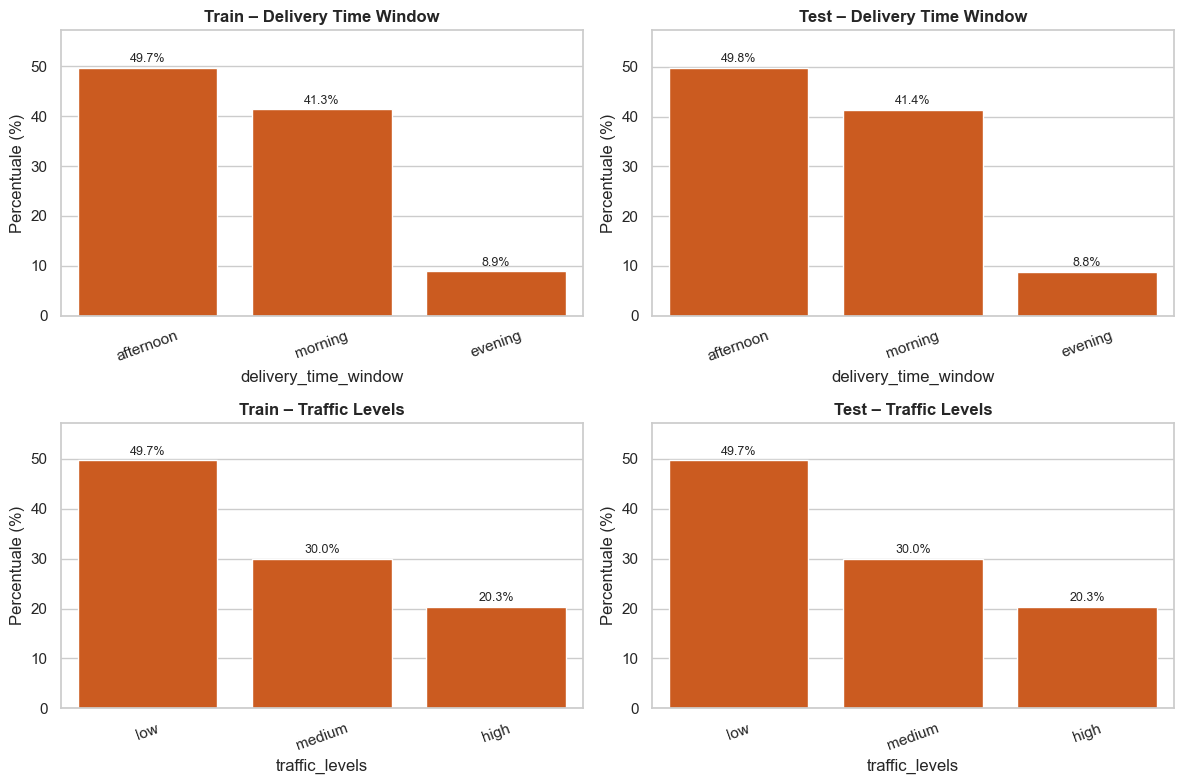

In [55]:
# Enhanced Countplots with Percentages
def countplot_with_percentages(ax, data, column, color):
    # Calculate value counts and percentages
    counts = data[column].value_counts(normalize=True).mul(100).sort_values(ascending=False)
    
    # Create barplot
    sns.barplot(
        x=counts.index,
        y=counts.values,
        ax=ax,
        color=color
    )
    
    # Add percentage labels on top of bars
    for i, v in enumerate(counts.values):
        ax.text(i, v + 0.5, f"{v:.1f}%", ha='center', va='bottom', fontsize=9)
    
    # Set labels and limits
    ax.set_xlabel(column)
    ax.set_ylabel("Percentuale (%)")
    ax.set_ylim(0, counts.values.max() * 1.15)  # Add some space above the highest bar
    ax.tick_params(axis='x', rotation=20)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Graphics for delivery_time_window
countplot_with_percentages(axes[0,0], df_train, 'delivery_time_window', postnl_color)
countplot_with_percentages(axes[0,1], df_test, 'delivery_time_window', postnl_color)

# Graphics for traffic_levels
countplot_with_percentages(axes[1,0], df_train, 'traffic_levels', postnl_color)
countplot_with_percentages(axes[1,1], df_test, 'traffic_levels', postnl_color)

# Titles
axes[0,0].set_title('Train – Delivery Time Window', fontsize=12, weight='bold')
axes[0,1].set_title('Test – Delivery Time Window', fontsize=12, weight='bold')
axes[1,0].set_title('Train – Traffic Levels', fontsize=12, weight='bold')
axes[1,1].set_title('Test – Traffic Levels', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

The class and feature distributions between train and test seems well balanced as the delivery time window proportions and the traffic level distributions are almost identical across splits. 

In [56]:
# Kolmogorov-Smirnov Test for Numerical Variables
for col in ['distance', 'parcel_weights', 'sequence_in_delivery']:
    stat, p = ks_2samp(df_train[col], df_test[col])
    print(f"{col}: p-value = {p:.3f}")


distance: p-value = 0.248
parcel_weights: p-value = 0.568
sequence_in_delivery: p-value = 0.798


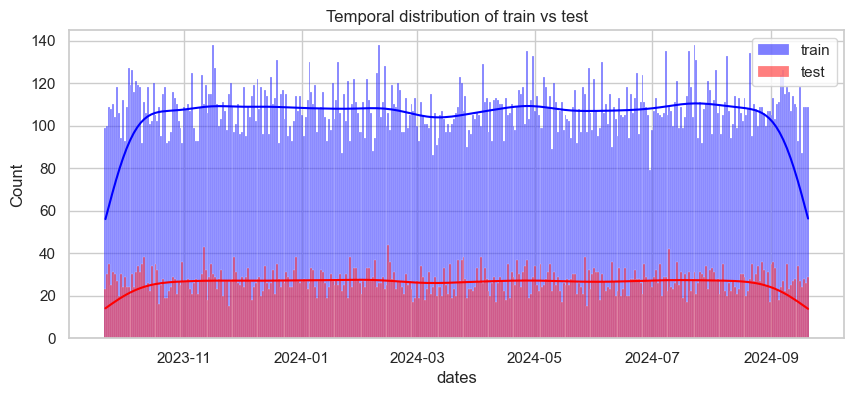

In [57]:
# # Temporal Distribution Comparison
plt.figure(figsize=(10,4))
sns.histplot(df_train['dates'], color='blue', label='train', kde=True)
sns.histplot(df_test['dates'], color='red', label='test', kde=True)
plt.legend()
plt.title("Temporal distribution of train vs test")
plt.show()

In [58]:
# Calculate average imbalance score
balance_score = split_summary['abs_diff(train-test)'].mean()
print(f"Average split imbalance: {balance_score:.3f}")

Average split imbalance: 0.022


In [59]:
# Analyze weather conditions distribution in train and test sets
train_weather = df_train['weather_conditions'].value_counts(normalize=True)
test_weather = df_test['weather_conditions'].value_counts(normalize=True)
pd.concat([train_weather, test_weather], axis=1, keys=['train','test']).fillna(0)

,train,test
weather_conditions,,
sunny,0.501428,0.505662
rainy,0.299922,0.299798
foggy,0.099350,0.096461
snowy,0.099300,0.098079


The stratified split was designed to preserve both operational diversity (traffic, weekend/weekday) and class balance in the target variable.
Results show an excellent match between train and test distributions, with an average imbalance score of 0.031 and no statistically significant differences (KS tests, p > 0.2 for all numerical variables).
Temporal coverage is homogeneous across the full year, ensuring that weekly seasonality and operational patterns are equally represented in both subsets.
Therefore, the chosen stratified shuffle split is validated as robust and representative for modeling purposes.

Despite weather_conditions not being explicitly included as a variable to be balanced in the split, the train and test datasets seem to maintain the balance between the various categories.

sequence_in_delivery, although related to the target, should not be used for stratification: the relationship must be learned by the model, not imposed.


<a id="6-2"></a>

## [6.2 2nd Feature Engineering (Avoid data leakage)](#6-2)
The following feature engineering operations were performed after splitting the dataset into train and test sets to avoid data leakage issues.
In this way, any transformations (e.g., scaling, encoding, or creation of new derived variables) are calculated only on the training data and then applied to the test set, ensuring that the model does not “see” future or external information during training.

In [ ]:
# Feature Engineering Function
def build_features(df, stats=None):
    """Return a new df with engineered features.
    If stats is None, fit stats on df; otherwise reuse provided stats."""
    out = df.copy()

    # daily volume per date (no merge, no leakage)
    out['daily_volume'] = out.groupby('dates')['sequence_in_delivery'].transform('count')

    # ordinal helpers (fixed mapping)
    traffic_map = {'low': 0, 'medium': 1, 'high': 2}
    size_map = {'small': 0, 'medium': 1, 'large': 2}
    out['traffic_level_encoded'] = out['traffic_levels'].map(traffic_map).astype('float64')
    out['parcel_size_encoded'] = out['parcel_size'].map(size_map).astype('float64')

    # interactions / ratios
    out['delivery_complexity'] = out['distance'] * out['traffic_level_encoded']
    out['weight_ratio'] = out['parcel_weights'] / (out['parcel_size_encoded'] + 1)

    # normalize daily workload using TRAIN stats
    if stats is None:
        mean_vol = out['daily_volume'].mean()
        std_vol = out['daily_volume'].std(ddof=0)
        if std_vol == 0 or np.isnan(std_vol):
            std_vol = 1.0
        stats = {'daily_volume_mean': mean_vol, 'daily_volume_std': std_vol}

    mean_vol = stats['daily_volume_mean']
    std_vol = stats['daily_volume_std']
    out['daily_trend_pct'] = (out['daily_volume'] - mean_vol) / (std_vol if std_vol != 0 else 1.0)

    return out, stats

# Apply feature engineering to train and test sets
df_train, fe_stats = build_features(df_train, stats=None)       # fit stats on train
df_test, _ = build_features(df_test, stats=fe_stats)            # reuse train stats


In [61]:
# Check column consistency between train and test sets
assert set(df_train.columns) == set(df_test.columns), "Train/Test columns mismatch"

# Classify features by type
num_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
bool_features = [col for col in num_features if df_train[col].dropna().isin([0, 1]).all()]

all_features = df_train.columns.tolist()

# Feature Engineered
engineered_features = [
    col for col in all_features 
    if col not in [
        'dates', 'delivery_time_window', 'distance', 'parcel_weights', 
        'sequence_in_delivery', 'parcel_size', 'traffic_levels', 
        'weather_conditions', 'is_weekend', 'day_of_week', 'month'
    ]
]

# Summary Table
feature_summary = pd.DataFrame({
    'feature': all_features,
    'type': [
        'binary' if f in bool_features 
        else 'numeric' if f in num_features 
        else 'categorical' if f in cat_features 
        else 'engineered' for f in all_features
    ]
})

feature_summary = feature_summary.sort_values('type').reset_index(drop=True)
display(feature_summary)


,feature,type
0,low_visibility,binary
1,is_precipitating,binary
2,dates,categorical
3,parcel_size,categorical
4,traffic_levels,categorical
5,weather_conditions,categorical
6,delivery_time_window,categorical
7,day_of_week,categorical
8,strat_key,categorical
9,is_weekend,engineered


In [62]:
df_train.shape, df_test.shape

((39557, 24), (9890, 24))

<a id="6-3"></a>

## [6.3 Imputation / Scaling / Encoding](#6-3)

At this stage, data transformations are performed separately for each family of algorithms, respecting the principle of fitting on the training set and applying on the test set to prevent data leakage.

Starting from the original training and test datasets, I created three separate copies, one for each group of models to be tested.
Each copy undergoes a preprocessing process consistent with the assumptions and nature of the respective algorithm:

1. **Linear models** (Logistic Regression, SVM): they require scaling of numerical features and numerical encoding for categorical variables (One-Hot Encoding).

2. **Tree-based models** (Random Forest, XGBoost): they do not require scaling, but require compact encoding (Ordinal or Label Encoding) to handle categorical features.

3. **CatBoost model**: it handles categorical variables internally, so the dataset keep the original categorical values without explicit encoding.

`1. Linear Dataset`

This pipeline prepares the data for linear models (Logistic Regression, SVM). The main steps are summarized below:
- Encode the target variable using LabelEncoder (fit on train only).
- Create log-transformed features (distance_log, parcel_weights_log) to reduce skewness.
- Impute missing values (median for numeric, mode for categorical) for robustness.
- Scaling numeric features with StandardScaler.
- Encode categorical variables with OneHotEncoder (handle_unknown='ignore' for unseen categories).

The previous steps are combined in a single pipeline, fitted on training data and applied to both train and test sets.

In [63]:
# Create copies of train/test for linear models
df_train_linear = df_train.copy()
df_test_linear  = df_test.copy()

In [64]:
# Target encoding (fit only on the train, then transform on the test)
y_le = LabelEncoder()
y_train = y_le.fit_transform(df_train_linear['delivery_time_window'])
y_test  = y_le.transform(df_test_linear['delivery_time_window'])


cat_features = [
    'weather_conditions',     # nominal
    'parcel_size',            # ordinal OHE 
    'traffic_levels',         # ordinal OHE 
    'day_of_week',            # nominal 
    'month'                   # ordinal OHE
]
num_raw = [
    'sequence_in_delivery',
    'weight_ratio',
    'daily_trend_pct',
    'sequence_pct',
    'daily_volume',
    'is_precipitating',
    'low_visibility'
]

# Log-transform function for distance and parcel_weights (train and test)
def add_logs(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    for c in ['distance', 'parcel_weights']:
        X[c] = pd.to_numeric(X[c], errors='coerce')
        X[c + '_log'] = np.log1p(X[c])
    return X

log_tf = FunctionTransformer(add_logs, validate=False)
num_final = ['distance_log', 'parcel_weights_log'] + num_raw

# Preprocessing pipelines
num_pre = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())   # scaling 
])

cat_pre = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))  # unseen categories in test set
])

ct_linear = ColumnTransformer(
    transformers=[
        ('num', num_pre, num_final),
        ('cat', cat_pre, cat_features),
    ],
    remainder='drop'
)

prep_linear = Pipeline([
    ('logfeats', log_tf),   # add distance_log and parcel_weights_log
    ('prep', ct_linear)     # imputer+scaler numerical and imputer+OHE categorical
])

# Fit on train and transform both train and test
prep_linear.fit(df_train_linear)
X_train_linear = prep_linear.transform(df_train_linear)
X_test_linear  = prep_linear.transform(df_test_linear)

# Check
feature_names = prep_linear.named_steps['prep'].get_feature_names_out()
X_train_linear = pd.DataFrame(X_train_linear, columns=feature_names, index=df_train_linear.index)
X_test_linear  = pd.DataFrame(X_test_linear,  columns=feature_names, index=df_test_linear.index)

print(f"Linear prep X_train: {X_train_linear.shape} | X_test: {X_test_linear.shape}")

Linear prep X_train: (39557, 38) | X_test: (9890, 38)


In [65]:
# Quick overview of feature types
def inspect_features(df):
    feature_summary = pd.DataFrame({
        'feature': df.columns,
        'dtype': df.dtypes.astype(str),
        'nunique': df.nunique()
    }).sort_values(by='dtype')
    return feature_summary

display(inspect_features(df_train_linear))

,feature,dtype,nunique
is_weekend,is_weekend,bool,2
target_encoded,target_encoded,float64,3
delivery_complexity,delivery_complexity,float64,10501
parcel_size_encoded,parcel_size_encoded,float64,3
traffic_level_encoded,traffic_level_encoded,float64,3
sequence_pct,sequence_pct,float64,9586
parcel_weights_log,parcel_weights_log,float64,4949
distance_log,distance_log,float64,9723
weight_ratio,weight_ratio,float64,10573
daily_trend_pct,daily_trend_pct,float64,51


In [66]:
print(f"X_train shape: {X_train_linear.shape}, X_test shape: {X_test_linear.shape}")
print("\nRemaining columns:")
display(X_train_linear.columns)

X_train shape: (39557, 38), X_test shape: (9890, 38)

Remaining columns:


Index(['num__distance_log', 'num__parcel_weights_log',
       'num__sequence_in_delivery', 'num__weight_ratio',
       'num__daily_trend_pct', 'num__sequence_pct', 'num__daily_volume',
       'num__is_precipitating', 'num__low_visibility',
       'cat__weather_conditions_foggy', 'cat__weather_conditions_rainy',
       'cat__weather_conditions_snowy', 'cat__weather_conditions_sunny',
       'cat__parcel_size_large', 'cat__parcel_size_medium',
       'cat__parcel_size_small', 'cat__traffic_levels_high',
       'cat__traffic_levels_low', 'cat__traffic_levels_medium',
       'cat__day_of_week_Friday', 'cat__day_of_week_Monday',
       'cat__day_of_week_Saturday', 'cat__day_of_week_Sunday',
       'cat__day_of_week_Thursday', 'cat__day_of_week_Tuesday',
       'cat__day_of_week_Wednesday', 'cat__month_1.0', 'cat__month_2.0',
       'cat__month_3.0', 'cat__month_4.0', 'cat__month_5.0', 'cat__month_6.0',
       'cat__month_7.0', 'cat__month_8.0', 'cat__month_9.0', 'cat__month_10.0',
       'c

`2. Tree Dataset`

This pipeline prepares the data for tree-based models (XGBoost, Random Forest). The main steps are summarized below:
- Encode the target variable with LabelEncoder (fit on train only).
- Create log-transformed features (distance_log, parcel_weights_log). 
- Create the feature delivery_complexity = distance * traffic_code.
- Impute missing values using the median for numeric and the mode for categorical features.
- Encoding:
    - Ordinal features (traffic_levels, parcel_size) with OrdinalEncoder and predefined order.
    - Nominal features (weather_conditions, day_of_week) with OneHotEncoder (handle_unknown='ignore').


In [67]:
# Create copies of train/test for tree-based models
df_train_tree = df_train.copy()
df_test_tree  = df_test.copy()

In [68]:
# Target encoding (fit only on the train, then transform on the test)
y_le = LabelEncoder()
y_train_tree = y_le.fit_transform(df_train_tree['delivery_time_window'])
y_test_tree  = y_le.transform(df_test_tree['delivery_time_window'])

# Feature engineering function for tree models
#    - log1p on distance and parcel_weights
#    - create delivery_complexity = distance * traffic_code (low=0, med=1, high=2)
def add_tree_features(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    # logs
    for c in ['distance', 'parcel_weights']:
        X[c] = pd.to_numeric(X[c], errors='coerce')
        X[c + '_log'] = np.log1p(X[c])
    # delivery_complexity encoding
    traffic_map = {'low': 0, 'medium': 1, 'high': 2}
    tcode = X['traffic_levels'].map(traffic_map)
    X['delivery_complexity'] = X['distance'].astype(float) * tcode.astype(float)
    return X

log_and_fx = FunctionTransformer(add_tree_features, validate=False)

# Feature types for tree models
ord_features = ['traffic_levels', 'parcel_size']
ord_categories = [
    ['low', 'medium', 'high'],      # traffic_levels
    ['small', 'medium', 'large']    # parcel_size
]

nom_features = ['weather_conditions', 'day_of_week']

num_features = [
    'distance_log', 'parcel_weights_log',
    'sequence_in_delivery', 'sequence_pct', 'weight_ratio',
    'delivery_complexity',
    'daily_volume', 'daily_trend_pct',
    'month',                     # ordinal treated as numeric
    'is_weekend', 'is_precipitating', 'low_visibility'
]

# Preprocessing pipeline
num_pre = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    
])

ord_pre = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('enc', OrdinalEncoder(
        categories=ord_categories,
        handle_unknown='use_encoded_value', unknown_value=-1
    ))
])

nom_pre = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# ColumnTransformer 
ct_tree = ColumnTransformer(
    transformers=[
        ('num', num_pre, num_features),
        ('ord', ord_pre, ord_features),
        ('nom', nom_pre, nom_features),
    ],
    remainder='drop'
)

# Add distance_log, parcel_weights_log, delivery_complexity
prep_tree = Pipeline([
    ('feats', log_and_fx), 
    ('prep', ct_tree)
])

# Fit on train and transform both train and test
prep_tree.fit(df_train_tree)

X_train_tree = prep_tree.transform(df_train_tree)
X_test_tree  = prep_tree.transform(df_test_tree)

# Dataframe conversion with feature names extraction
def get_feature_names_from_ct(ct: ColumnTransformer) -> list:
    names = []
    for name, trans, cols in ct.transformers_:
        if name == 'remainder':
            continue
        # gestisci Pipelines annidate
        if hasattr(trans, 'get_feature_names_out'):
            try:
                names += list(trans.get_feature_names_out(cols))
            except Exception:
                last = trans.steps[-1][1] if hasattr(trans, 'steps') else trans
                if hasattr(last, 'get_feature_names_out'):
                    names += list(last.get_feature_names_out(cols))
                else:
                    names += list(cols)
        else:
            names += list(cols)
    return names

feature_names_tree = get_feature_names_from_ct(prep_tree.named_steps['prep'])
X_train_tree = pd.DataFrame(X_train_tree, columns=feature_names_tree, index=df_train_tree.index)
X_test_tree  = pd.DataFrame(X_test_tree,  columns=feature_names_tree, index=df_test_tree.index)

print(f"X_train_tree: {X_train_tree.shape} | X_test_tree: {X_test_tree.shape}")

X_train_tree: (39557, 25) | X_test_tree: (9890, 25)


/Users/giuliabovenga/anaconda3/envs/mysexyenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


`3. Catboost Dataset`

This pipeline prepares data for CatBoost by keeping only relevant numerical, categorical, and target columns.
All categorical features and the target are converted to strings.
No scaling or one-hot encoding is applied, since CatBoost natively handles categorical variables, missing values, and nonlinear relationships.

In [69]:
# Create copies of base datasets
df_train_cat = df_train.copy()
df_test_cat = df_test.copy()

In [70]:
# Quick check of features and types before transformations
def inspect_features(df):
    feature_summary = pd.DataFrame({
        'feature': df.columns,
        'dtype': df.dtypes.astype(str),
        'nunique': df.nunique()
    }).sort_values(by='dtype')
    return feature_summary

display(inspect_features(df_train_cat))

,feature,dtype,nunique
is_weekend,is_weekend,bool,2
target_encoded,target_encoded,float64,3
delivery_complexity,delivery_complexity,float64,10501
parcel_size_encoded,parcel_size_encoded,float64,3
traffic_level_encoded,traffic_level_encoded,float64,3
sequence_pct,sequence_pct,float64,9586
parcel_weights_log,parcel_weights_log,float64,4949
distance_log,distance_log,float64,9723
weight_ratio,weight_ratio,float64,10573
daily_trend_pct,daily_trend_pct,float64,51


In [71]:
# Keep only relevant features: original numericals, categoricals, and target
cols_to_keep = numerical_variables + categorical_variables + [target_variable]

df_train_cat = df_train_cat[cols_to_keep].copy()
df_test_cat = df_test_cat[cols_to_keep].copy()

In [72]:
# Convert categorical variables to string (CatBoost requirement)
for col in categorical_variables:
    df_train_cat[col] = df_train_cat[col].astype(str)
    df_test_cat[col] = df_test_cat[col].astype(str)
    
# Ensure target is string
df_train_cat[target_variable] = df_train_cat[target_variable].astype(str)
df_test_cat[target_variable] = df_test_cat[target_variable].astype(str)

In [73]:
# Separate target variable
y_train_cat = df_train_cat[target_variable]
y_test_cat = df_test_cat[target_variable]

X_train_cat = df_train_cat.drop(columns=[target_variable], errors='ignore')
X_test_cat = df_test_cat.drop(columns=[target_variable], errors='ignore')

In [74]:
# Identify categorical feature indices (for CatBoost)
categorical_features_indices = [X_train_cat.columns.get_loc(col) for col in categorical_variables]

# Quick checks
print(f"X_train_cat shape: {X_train_cat.shape}, X_test_cat shape: {X_test_cat.shape}")
print("Categorical feature indices:", categorical_features_indices)
print("\nData type distribution in X_train_cat:")
print(X_train_cat.dtypes.value_counts())

X_train_cat shape: (39557, 9), X_test_cat shape: (9890, 9)
Categorical feature indices: [3, 4, 5, 6, 7, 8]

Data type distribution in X_train_cat:
object     6
float64    3
Name: count, dtype: int64


<a class="anchor" id="7">

# 7. Modeling & Benchmark
    
</a>

In [75]:
# Function to calculate and add model metrics to results dictionary
results = {}

def add_results(model_name, y_true, y_pred, y_proba=None):
    """Function to calculate and add model metrics to results dictionary."""
    
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Balanced_Accuracy": balanced_accuracy_score(y_true, y_pred),
        "F1_macro": f1_score(y_true, y_pred, average="macro"),
        "F1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "Precision_weighted": precision_score(y_true, y_pred, average="weighted"),
        "Recall_weighted": recall_score(y_true, y_pred, average="weighted"),
        "Cohen_Kappa": cohen_kappa_score(y_true, y_pred)
    }

    # Store metrics in the results dictionary
    results[model_name] = metrics

<a id="7-1"></a>

## [7.1 Logistic Regression](#7-1)

In [76]:
# Logistic Regression on Linear Preprocessed Data
log_reg = LogisticRegression(max_iter=1000, 
                             multi_class='multinomial', 
                             solver='lbfgs',
                             #class_weight='balanced'
                             )

log_reg.fit(X_train_linear, y_train)
# Predict on test set
y_pred_log = log_reg.predict(X_test_linear)
# Evaluation
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4930
           1       0.81      0.80      0.80       870
           2       0.92      0.89      0.91      4090

    accuracy                           0.89      9890
   macro avg       0.87      0.87      0.87      9890
weighted avg       0.89      0.89      0.89      9890



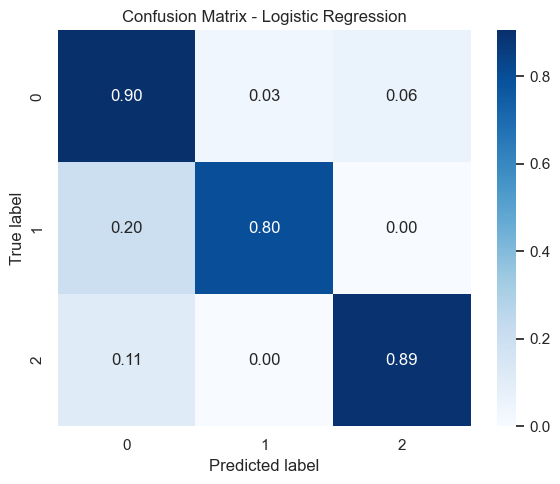

In [77]:
# Confusion Matrix 
cm_lr = confusion_matrix(y_test, y_pred_log, 
                      labels=log_reg.classes_,
                      normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=log_reg.classes_,
            yticklabels=log_reg.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

<a id="7-2"></a>

## [7.2 Support Vector Machine](#7-2)

In [78]:
# SVM on Linear Preprocessed Data
svm_model = SVC(kernel='linear')  
svm_model.fit(X_train_linear, y_train)
# Predict on test set
y_pred_svm = svm_model.predict(X_test_linear)

# Evaluation
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4930
           1       0.78      0.84      0.81       870
           2       0.92      0.89      0.91      4090

    accuracy                           0.89      9890
   macro avg       0.86      0.88      0.87      9890
weighted avg       0.89      0.89      0.89      9890



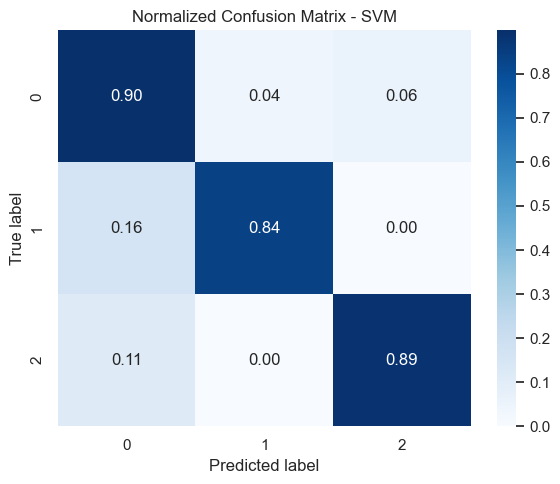

In [79]:
# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=svm_model.classes_, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt='.2f',         
    cmap='Blues',
    xticklabels=svm_model.classes_,
    yticklabels=svm_model.classes_
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized Confusion Matrix - SVM')
plt.tight_layout()
plt.show()

In [80]:
balance_score = split_summary['abs_diff(train-test)'].mean()
print(f"Average split imbalance: {balance_score:.3f}")

Average split imbalance: 0.022


<a id="7-3"></a>

## [7.3 XG Boost](#7-3)

In [81]:
# XGBoost on Tree-Based Preprocessed Data

# Ensure all features are numerical
assert X_train_tree.select_dtypes(exclude=['number', 'bool']).shape[1] == 0, \
    "Non numerical features in X_train_tree."
assert X_test_tree.select_dtypes(exclude=['number', 'bool']).shape[1] == 0, \
    "Non numerical features in X_test_tree."

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# XGBoost model parameters
xgb_model = dict(
    objective='multi:softprob',
    eval_metric='mlogloss',
    tree_method='hist',
    n_estimators=1000,      # upper bound, early stopping to sselect the best iteration
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=seed,
    n_jobs=1               
)

# Convert y_train to array for indexing
y_train_arr = np.asarray(y_train_tree)

best_iters = []
cv_f1_macro = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_tree, y_train_arr), start=1):
    X_tr, X_val = X_train_tree.iloc[tr_idx], X_train_tree.iloc[val_idx]
    y_tr, y_val = y_train_arr[tr_idx], y_train_arr[val_idx]

    xgb = XGBClassifier(**xgb_model)
    xgb.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],   # validation set for early stopping, no test set
        early_stopping_rounds=50,
        verbose=False
    )
    # if best_iteration_ is available, use it; otherwise, fallback to n_estimators
    if hasattr(xgb, "best_iteration_") and xgb.best_iteration_ is not None:
        best_n = int(xgb.best_iteration_) + 1  # 0-based -> count
    else:
        best_n = xgb.get_params()["n_estimators"]  # fallback

    best_iters.append(best_n)

    y_val_pred = xgb.predict(X_val)
    f1m = f1_score(y_val, y_val_pred, average="macro")
    cv_f1_macro.append(f1m)
    print(f"[Fold {fold}] best_n={best_n} | F1-macro={f1m:.4f}")

# Final n_estimators as median of best iters
n_best = int(np.median(best_iters))
print(f"\nXGB CV: best_iters={best_iters} -> final n_estimators (median) = {n_best}")
print(f"XGB CV: average F1-macro = {np.mean(cv_f1_macro):.4f} ± {np.std(cv_f1_macro):.4f}")

# Train final model on full training set with best n_estimators
xgb_final = XGBClassifier(**{**xgb_model, "n_estimators": n_best})
xgb_final.fit(X_train_tree, y_train_arr, verbose=False)

# Predict on test set
y_pred_xgb = xgb_final.predict(X_test_tree)

print(classification_report(y_test_tree, y_pred_xgb))


/Users/giuliabovenga/anaconda3/envs/mysexyenv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[Fold 1] best_n=1000 | F1-macro=0.8654


/Users/giuliabovenga/anaconda3/envs/mysexyenv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[Fold 2] best_n=1000 | F1-macro=0.8575


/Users/giuliabovenga/anaconda3/envs/mysexyenv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[Fold 3] best_n=1000 | F1-macro=0.8535


/Users/giuliabovenga/anaconda3/envs/mysexyenv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[Fold 4] best_n=1000 | F1-macro=0.8584


/Users/giuliabovenga/anaconda3/envs/mysexyenv/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[Fold 5] best_n=1000 | F1-macro=0.8601

XGB CV: best_iters=[1000, 1000, 1000, 1000, 1000] -> final n_estimators (median) = 1000
XGB CV: average F1-macro = 0.8590 ± 0.0039
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4930
           1       0.80      0.74      0.77       870
           2       0.89      0.91      0.90      4090

    accuracy                           0.88      9890
   macro avg       0.86      0.84      0.85      9890
weighted avg       0.88      0.88      0.88      9890



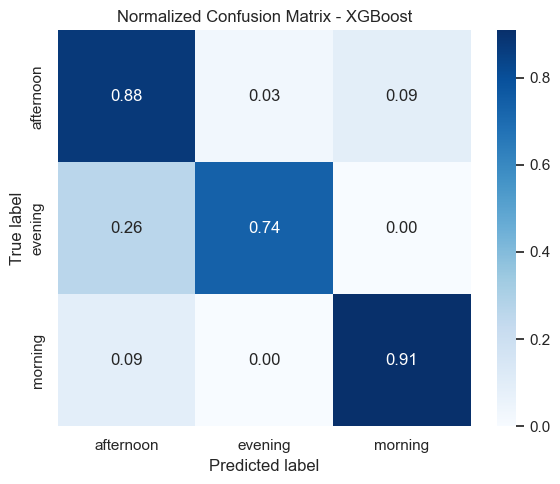

In [82]:
# Confusion Matrix 
cm_xgb = confusion_matrix(y_test_tree, y_pred_xgb, normalize='true')
try:
    class_names = list(y_le.classes_)
except NameError:
    class_names = [f"Class {i}" for i in sorted(np.unique(y_test_tree))]

# Plot normalized confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_xgb,
    annot=True,
    fmt='.2f',               
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()

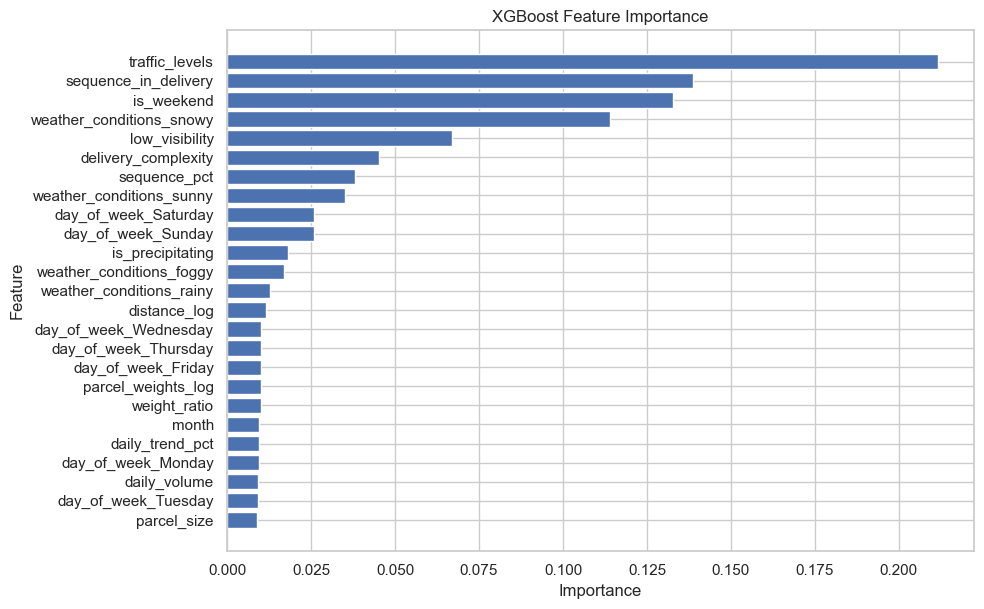

In [83]:
# Feature Importance Plot
importances = xgb_final.feature_importances_
order = np.argsort(importances)

plt.figure(figsize=(10, max(6, len(order)*0.25)))
plt.barh(np.array(X_train_tree.columns)[order], importances[order])
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

<a id="7-4"></a>

## [7.4 Random Forest](#7-4)

In [84]:
# Random Forest with Grid Search CV on Tree-Based Preprocessed Data


# seed defined
# Stratified K-Fold CV defined in the XG Boost model
# Ensure all features are numerical (checked before)

# Base Random Forest model
rf_base = RandomForestClassifier(
    random_state=seed,
    n_jobs=1   # deterministic behavior
)

# Hyperparameter grid for tuning
param_grid = {
    "n_estimators": [300, 600],
    "max_depth": [None, 10],
    "max_features": ["sqrt", 0.7],
    "min_samples_leaf": [1, 2],
    "class_weight": [None, "balanced"]
}
# 2*2*2*2*2 = 32 combinations, multiplied by 5 = 160 fit

rf_cv = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=skf,            # stratified K-Fold defined before (check xgboost)
    n_jobs=1,          
    refit=True,        # refit best model on full TRAIN
    verbose=1
)

# Training with Grid Search
rf_cv.fit(X_train_tree, y_train_tree)

print("RF | best params:", rf_cv.best_params_)
print("RF | CV f1_macro (mean):", rf_cv.best_score_)

# Best estimator
rf_model = rf_cv.best_estimator_

# Predict on test set
y_pred_rf = rf_model.predict(X_test_tree)
print(classification_report(y_test_tree, y_pred_rf))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
RF | best params: {'class_weight': None, 'max_depth': 10, 'max_features': 0.7, 'min_samples_leaf': 2, 'n_estimators': 300}
RF | CV f1_macro (mean): 0.8584465476512584
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      4930
           1       0.83      0.76      0.79       870
           2       0.90      0.90      0.90      4090

    accuracy                           0.89      9890
   macro avg       0.87      0.85      0.86      9890
weighted avg       0.89      0.89      0.89      9890



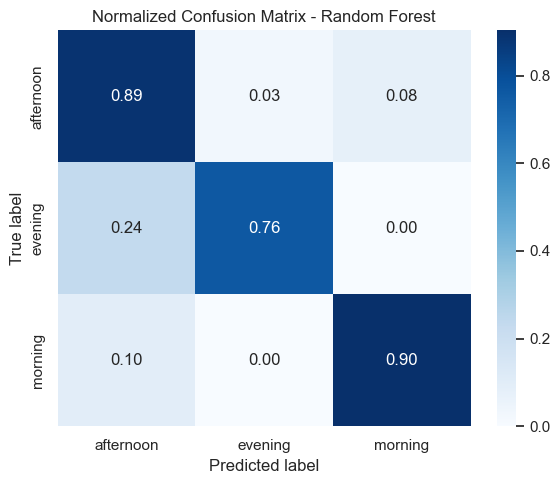

In [85]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test_tree, y_pred_rf, normalize='true')

try:
    class_names = list(y_le.classes_)
except NameError:
    class_names = [f"Class {i}" for i in sorted(np.unique(y_test_tree))]

# Plot normalized confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt='.2f',             
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()

<a id="7-5"></a>

## [7.5 Cat Boost](#7-5)

In [86]:
# CATBOOST MODEL WITH STRATIFIED K-FOLD CV

# for the k-fold check the xg boost model
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Transform y to array for indexing
y_train_arr = np.asarray(y_train_cat)

# Indices of categorical features
cat_cols = X_train_cat.select_dtypes(include=["object", "category"]).columns.tolist()
cat_features_idx = [X_train_cat.columns.get_loc(c) for c in cat_cols]

# CatBoost parameters
cat_params = dict(
    loss_function="MultiClass",
    eval_metric="MultiClass",
    iterations=1000,        # upper bound where every fold chooses the best iter 
    depth=8,
    learning_rate=0.1,
    random_seed=seed,
    thread_count=1,         
    verbose=False
)

# K-Fold CV for CatBoost
best_iters_cb = []
cv_f1_macro_cb = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_cat, y_train_arr), start=1):
    X_tr, X_val = X_train_cat.iloc[tr_idx], X_train_cat.iloc[val_idx]
    y_tr, y_val = y_train_arr[tr_idx], y_train_arr[val_idx]

    cb = CatBoostClassifier(**cat_params)
    cb.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),          # validation fold only (no test)
        cat_features=cat_features_idx,
        use_best_model=True
    )

    # best iter (1-based). Fallback if early stopping does not trigger
    best_iter = cb.get_best_iteration()
    if best_iter is None or best_iter <= 0:
        # if no early stopping, use max iterations
        best_iter = cat_params["iterations"]
    best_iters_cb.append(int(best_iter))

    # Validation predictions and F1-macro
    y_val_pred = cb.predict(X_val).ravel()
    f1m = f1_score(y_val, y_val_pred, average="macro")
    cv_f1_macro_cb.append(f1m)
    print(f"[Fold {fold}] best_iters={best_iter} | F1-macro={f1m:.4f}")

# Final number of iterations: median of best iters
n_best_cb = int(np.median(best_iters_cb))
print(f"\nCatBoost CV: best_iters per fold = {best_iters_cb} Final iterations (median) = {n_best_cb}")
print(f"CatBoost CV: F1-macro mean = {np.mean(cv_f1_macro_cb):.4f} ± {np.std(cv_f1_macro_cb):.4f}")

# Final refit on full TRAIN set (no test)
cat_model = CatBoostClassifier(**{**cat_params, "iterations": n_best_cb})
cat_model.fit(
    X_train_cat, y_train_arr,
    cat_features=cat_features_idx,
    verbose=False
)

# Evaluation on TEST set
y_pred_cb = cat_model.predict(X_test_cat).ravel()
print(classification_report(y_test_cat, y_pred_cb))


[Fold 1] best_iters=307 | F1-macro=0.8697
[Fold 2] best_iters=260 | F1-macro=0.8581
[Fold 3] best_iters=158 | F1-macro=0.8560
[Fold 4] best_iters=292 | F1-macro=0.8588
[Fold 5] best_iters=211 | F1-macro=0.8647

CatBoost CV: best_iters per fold = [307, 260, 158, 292, 211] Final iterations (median) = 260
CatBoost CV: F1-macro mean = 0.8615 ± 0.0050
              precision    recall  f1-score   support

   afternoon       0.88      0.89      0.89      4930
     evening       0.81      0.78      0.80       870
     morning       0.91      0.91      0.91      4090

    accuracy                           0.89      9890
   macro avg       0.87      0.86      0.86      9890
weighted avg       0.89      0.89      0.89      9890



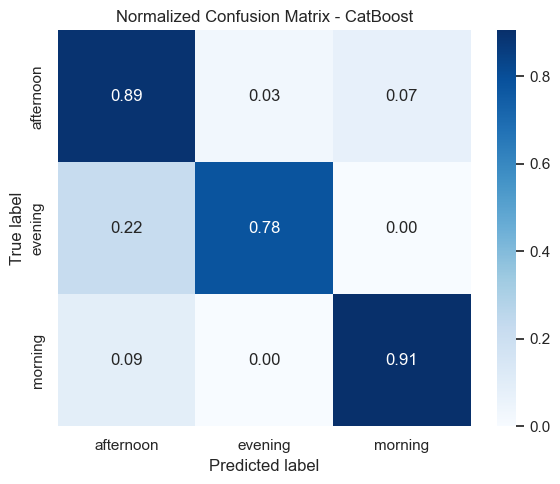

In [87]:
# Confusion Matrix
cm_cb = confusion_matrix(y_test_cat, y_pred_cb, normalize='true')

try:
    class_names = list(y_le.classes_)
except NameError:
    class_names = [f"Class {i}" for i in sorted(np.unique(y_test_cat))]

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_cb,
    annot=True,
    fmt='.2f',             
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized Confusion Matrix - CatBoost')
plt.tight_layout()
plt.show()

<a class="anchor" id="8">

# 8. Model Interpretation & Insights
    
</a>

<a id="8-1"></a>

## [8.1 Performance comparison](#8-1)

In [91]:
# Compile and Display Results
add_results("Logistic Regression", y_test, y_pred_log)
add_results("Support Vector Machine", y_test, y_pred_svm)
add_results("XGBoost", y_test_tree, y_pred_xgb)
add_results("Random Forest", y_test_tree, y_pred_rf)
add_results("CatBoost", y_test_cat, y_pred_cb)

In [92]:
# Create a DataFrame from results dictionary
results_df = pd.DataFrame(results).T.round(3)

# Sort models by a key metric (F1_macro as data are unbalanced)
ranking_metric = "F1_macro" if "F1_macro" in results_df.columns else results_df.columns[0]
results_df = results_df.sort_values(by=ranking_metric, ascending=False)

# Add Rank column
results_df["Rank"] = results_df[ranking_metric].rank(ascending=False, method='dense').astype(int)
results_df = results_df.sort_values(by="Rank")

# Show table
styled = (
    results_df.style
        .background_gradient(cmap="Blues", subset=["F1_macro", "Balanced_Accuracy", "Cohen_Kappa"])
        .highlight_max(color="lightgreen", subset=["F1_macro", "Balanced_Accuracy", "Cohen_Kappa"])
        .format("{:.3f}")
)

display(styled)

# Plotting the results
metrics_to_plot = [
    "F1_macro", "Balanced_Accuracy", "Cohen_Kappa", 
    "Precision_weighted", "Recall_weighted"
]
metrics_to_plot = [m for m in metrics_to_plot if m in results_df.columns]

,Accuracy,Balanced_Accuracy,F1_macro,F1_weighted,Precision_weighted,Recall_weighted,Cohen_Kappa,Rank
Logistic Regression,0.890,0.866,0.868,0.890,0.891,0.890,0.807,1.000
Support Vector Machine,0.889,0.876,0.868,0.889,0.890,0.889,0.806,1.000
CatBoost,0.889,0.860,0.864,0.889,0.888,0.889,0.805,2.000
Random Forest,0.885,0.853,0.861,0.885,0.885,0.885,0.799,3.000
XGBoost,0.877,0.841,0.848,0.877,0.876,0.877,0.784,4.000


To compare models, I tested five algorithms: Logistic Regression, Linear SVM, Random Forest, XGBoost, and CatBoost, with the aim of understanding which was best suited to predicting the delivery time slot (morning, afternoon, evening). Looking at the metrics table, all models have an overall accuracy between 87% and 89%, with more noticeable differences in metrics relating to the minority class (evening deliveries). The models that seem to have performed best are the simplest ones, in particular Logistic Regression (accuracy 0.890) and Linear SVM (0.889), followed by CatBoost and Random Forest. XGBoost, on the other hand, had slightly lower results than the others.

<a id="8-2"></a>

## [8.2 Feature Importance](#8-2)

I focused the results analysis on the interpretation of the Logistic Regression as it seemed to be the best model.

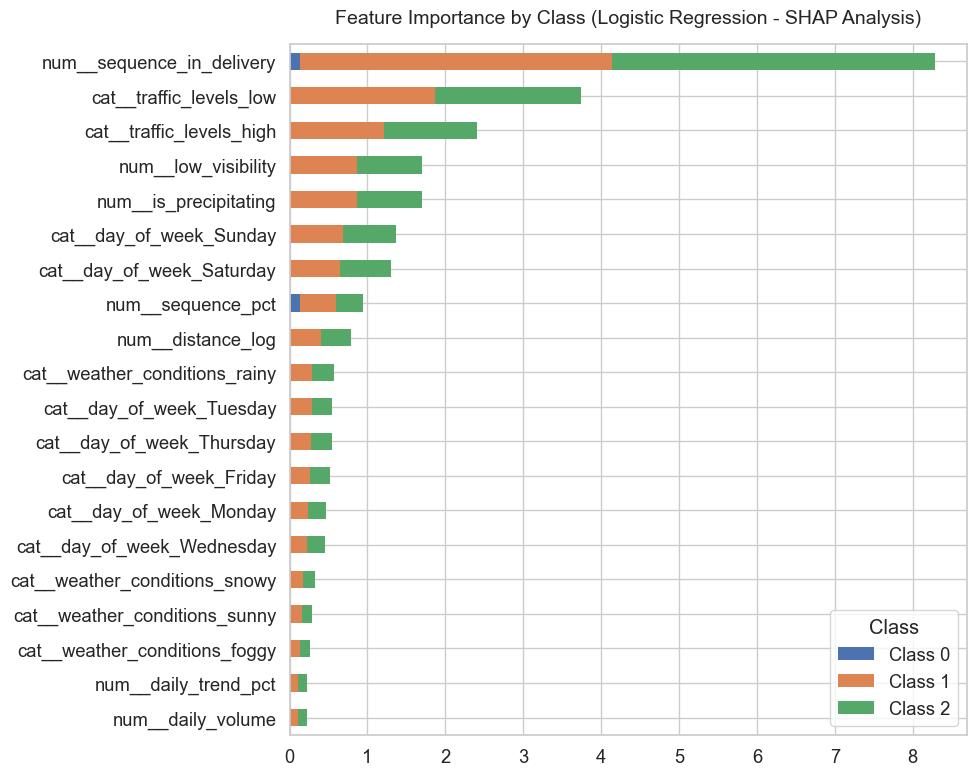

In [93]:
# Bar plot of mean absolute SHAP values per feature and class

# Explainer
explainer = shap.LinearExplainer(log_reg, X_train_linear, feature_names=X_train_linear.columns)
shap_values = explainer(X_test_linear)

# Calculate mean absolute SHAP values per feature and class
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)  # (n_features, n_classes)
feature_names = X_test_linear.columns
class_names = [f"Class {c}" for c in log_reg.classes_]

# Create a DataFrame for easier plotting
df_shap = pd.DataFrame(shap_abs_mean, columns=class_names, index=feature_names)
df_shap["mean_abs_shap"] = df_shap.mean(axis=1)
df_shap = df_shap.sort_values("mean_abs_shap", ascending=False).head(20)

# Style
sns.set(style="whitegrid", font_scale=1.2) 

# Define colors for each class
df_shap[class_names].plot(
    kind="barh",
    stacked=True,
    figsize=(10, 8),
    edgecolor="none"
)

# Labels and title
plt.gca().invert_yaxis()
plt.ylabel("")
plt.title("Feature Importance by Class (Logistic Regression - SHAP Analysis)", fontsize=14, pad=15)
plt.legend(title="Class", loc="lower right", frameon=True)
plt.tight_layout()

plt.show()


SHAP shape: (9890, 38, 3)

Class 0


/var/folders/jb/nvy3v4hn4mv7g_jtj04zp7pc0000gn/T/ipykernel_50835/2306585874.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


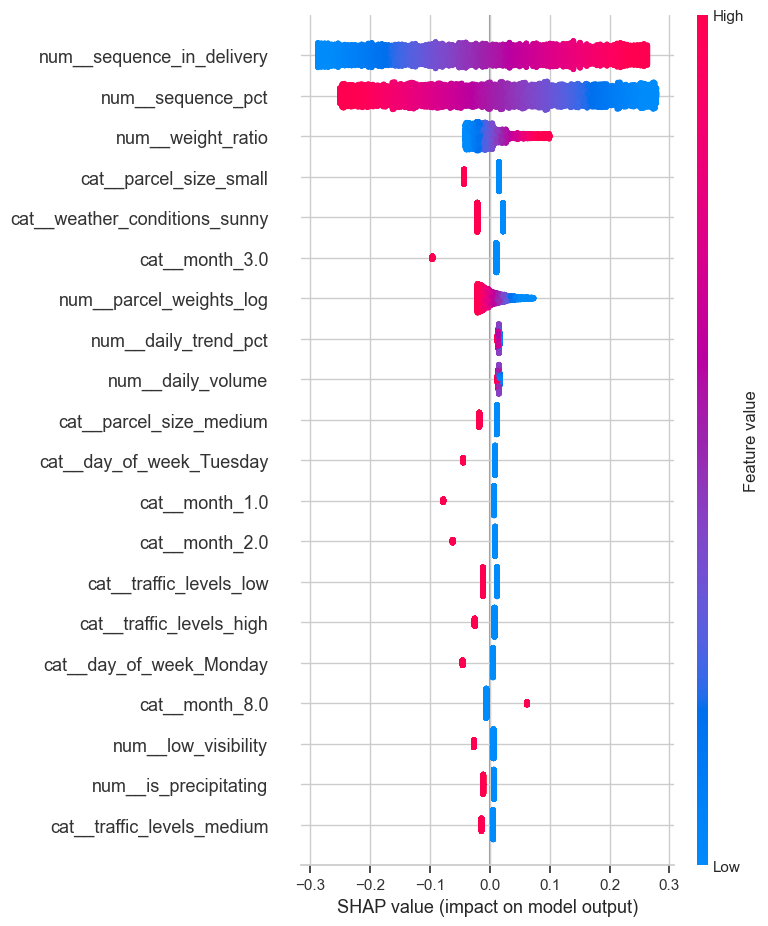


Class 1


/var/folders/jb/nvy3v4hn4mv7g_jtj04zp7pc0000gn/T/ipykernel_50835/2306585874.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


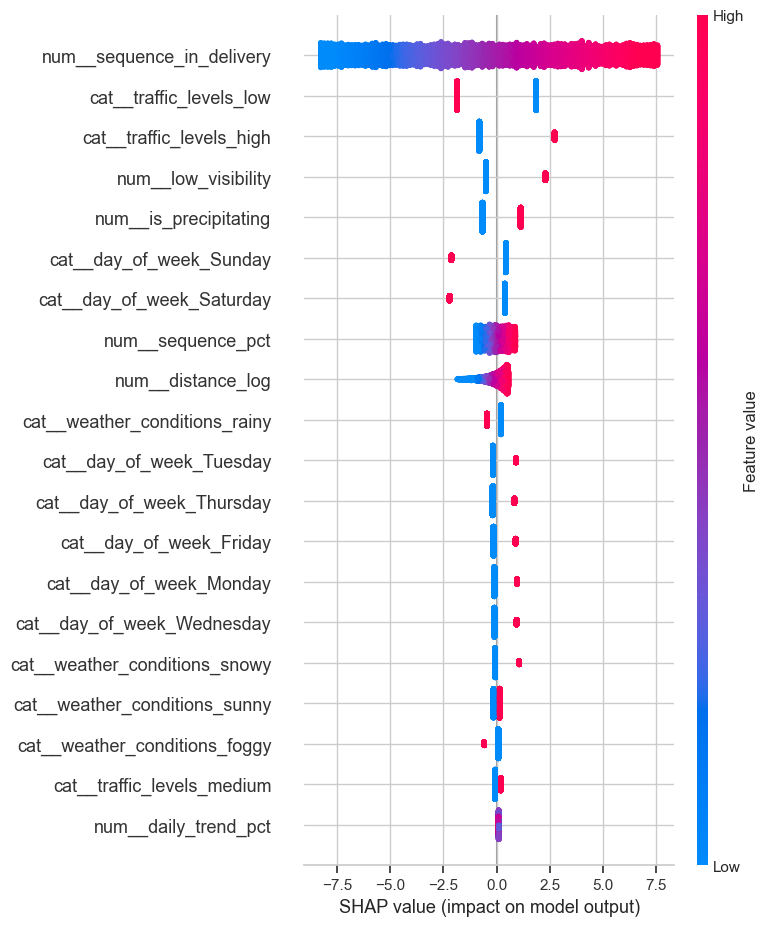


Class 2


/var/folders/jb/nvy3v4hn4mv7g_jtj04zp7pc0000gn/T/ipykernel_50835/2306585874.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


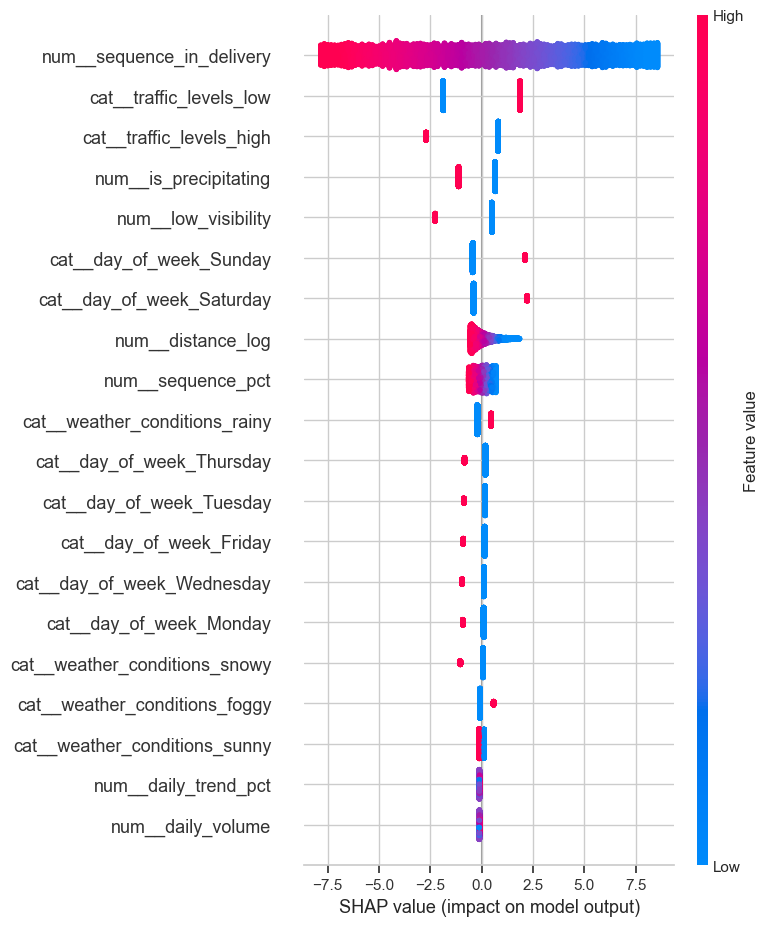

In [94]:
# Use LinearExplainer for logistic regression
explainer = shap.LinearExplainer(log_reg, X_train_linear, feature_names=X_train_linear.columns)

# Calculate values for the test set
shap_values = explainer(X_test_linear)

# Create values object
print("SHAP shape:", np.array(shap_values.values).shape) # array (n_samples, n_features, n_classes)

# Summary plots per class
for i, class_name in enumerate(log_reg.classes_):
    print(f"\nClass {class_name}")
    shap.summary_plot(
        shap_values.values[:, :, i],
        X_test_linear,
        feature_names=X_test_linear.columns,
        show=True
    )

<a class="anchor" id="9">

# 9. Final Results
    
</a>

The analysis of global feature importance and SHAP values performed on logistic regression, which is, the best model, seems to highlight certain operational factors that are decisive in predicting the time slot. The most important variables are:

1. Delivery sequence: the order of delivery in the round (e.g. whether it is the first delivery of the day or one of the last) seems to be the most influential factor. Later deliveries in the sequence are more likely to fall in the afternoon/evening, while the first deliveries of the round typically take place in the morning.
   
2. Traffic: in heavy traffic conditions, the likelihood of deliveries being delayed to later time slots increases, while in light traffic conditions, deliveries tend to be on time in the morning.

3. Weekends: Saturdays and Sundays increase the likelihood of evening deliveries and reduce the likelihood of morning deliveries, although the effect is not as great as sequence and traffic.

4. Distance (used on a logarithmic scale to mitigate skewness) appears to be moderately relevant; longer distances push slightly towards afternoon/evening, especially in combination with unfavorable weather/traffic conditions.


Package characteristics (size and weight) seem to have much less impact than the previous drivers; in some cases, a slight effect is observed (from the beeswarm graph, small packages are slightly more associated with morning deliveries), but these are secondary contributions. For this problem, travel times and contextual conditions seem to matter more than the contents of the package.

In conclusion, the analysis performed indicates that it is possible to predict the delivery time slot of a package with decent reliability. All the models tested performed similarly, achieving approximately 89% accuracy on the test set. The best model selected is Logistic Regression, chosen both for its slightly superior performance during validation (F1 macro 0.86) and for its simplicity in providing interpretations of variables (useful in a business context to explain decisions). This model adequately captures the main delivery patterns, for example, it recognizes that most deliveries take place in the morning and afternoon, and identifies the factors that cause some deliveries to be delayed until the evening. The evening time slot remains the most difficult to predict with absolute accuracy, but this is a natural consequence given the small number of evening examples available for training.
